# Packages/ Imports

In [1]:
'''
Update conda env using the following line in the /environment directory
    ` conda env update --file ml_portfolio_opt_env_<OS>.yml --prune `
'''

'\nUpdate conda env using the following line in the /environment directory\n    ` conda env update --file ml_portfolio_opt_env_<OS>.yml --prune `\n'

In [2]:
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import yfinance as yf
import statsmodels
import pyfolio as pf

# Import libraries for ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from src.myarima import MyARIMA
from src.init_dataset import InitDataset
from src.mykmeans import MyKMeans
import src.utils as utils
from src.mptoptimizer import MPTOptimizer
from src.dbscan import MyDBSCAN
from src.myLSTM import MyLSTM

print("Finished importing utils!")

Finished importing utils!


# Data Management

In [3]:
#Since dataset has been created, init is set to false
InitDataset.create_econ_data(init=False)
InitDataset.create_merged_stock_data(init=False)
InitDataset.create_adj_closed_price(init=False)

## Data Exploration

In [4]:
# Load the dataset for the first ticker
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
stock_data = pd.read_csv(r'dataset/stock_data/AAPL_data.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
stock_data.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2018-01-02  42.540001  43.075001  42.314999  43.064999  40.670986  102223600   
2018-01-03  43.132500  43.637501  42.990002  43.057499  40.663898  118071600   
2018-01-04  43.134998  43.367500  43.020000  43.257500  40.852768   89738400   
2018-01-05  43.360001  43.842499  43.262501  43.750000  41.317894   94640000   
2018-01-08  43.587502  43.902500  43.482498  43.587502  41.164425   82271200   

           ticker  
Date               
2018-01-02   AAPL  
2018-01-03   AAPL  
2018-01-04   AAPL  
2018-01-05   AAPL  
2018-01-08   AAPL

In [5]:
# Check the shape of the dataset
print(stock_data.shape)

# Check the start and end date of the dataset
print(stock_data.index.min())
print(stock_data.index.max())

# Duration of stock data
duration = stock_data.index.max() - stock_data.index.min()
print(duration)

(1509, 7)
2018-01-02 00:00:00
2023-12-29 00:00:00
2187 days 00:00:00


In [6]:
# Data Cleaning and Sanity Check
# Check for missing values
print(stock_data.isnull().sum(), '\n')
# Check for duplicate values
print(stock_data.duplicated().sum())
# Describe the dataset
print(stock_data.describe())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
ticker       0
dtype: int64 

0
              Open         High          Low        Close    Adj Close  \
count  1509.000000  1509.000000  1509.000000  1509.000000  1509.000000   
mean    110.326080   111.583562   109.157902   110.428236   108.703985   
std      51.003328    51.520038    50.513390    51.043671    51.349589   
min      35.994999    36.430000    35.500000    35.547501    34.075390   
25%      54.105000    54.794998    53.290001    53.872501    51.655396   
50%     123.660004   124.980003   122.139999   123.540001   121.447418   
75%     152.570007   154.559998   150.800003   152.740005   151.446182   
max     198.020004   199.619995   197.000000   198.110001   197.857529   

             Volume  
count  1.509000e+03  
mean   1.073273e+08  
std    5.513331e+07  
min    2.404830e+07  
25%    7.078370e+07  
50%    9.296430e+07  
75%    1.280440e+08  
max    4.265100e+08  


# Initial Data Visualization

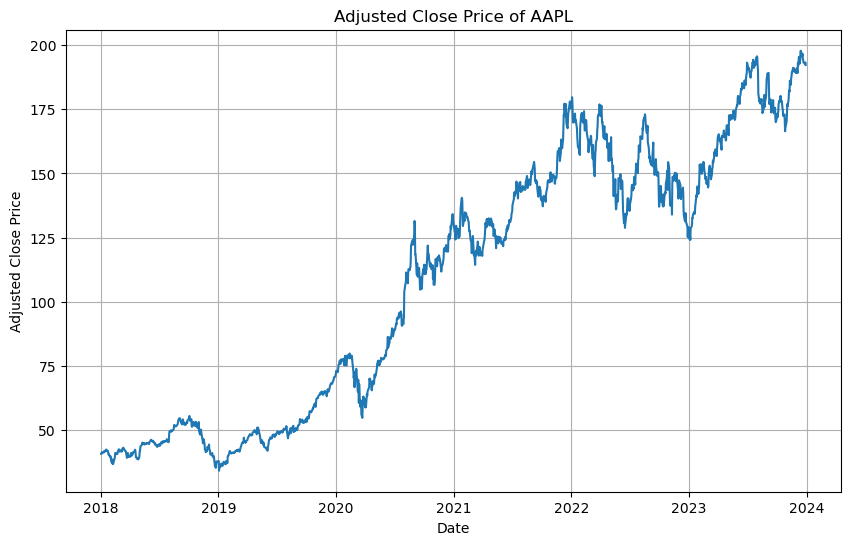

In [7]:
# Plot the adjusted close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.title('Adjusted Close Price of AAPL')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.plot(stock_data['Adj Close'])
plt.show()

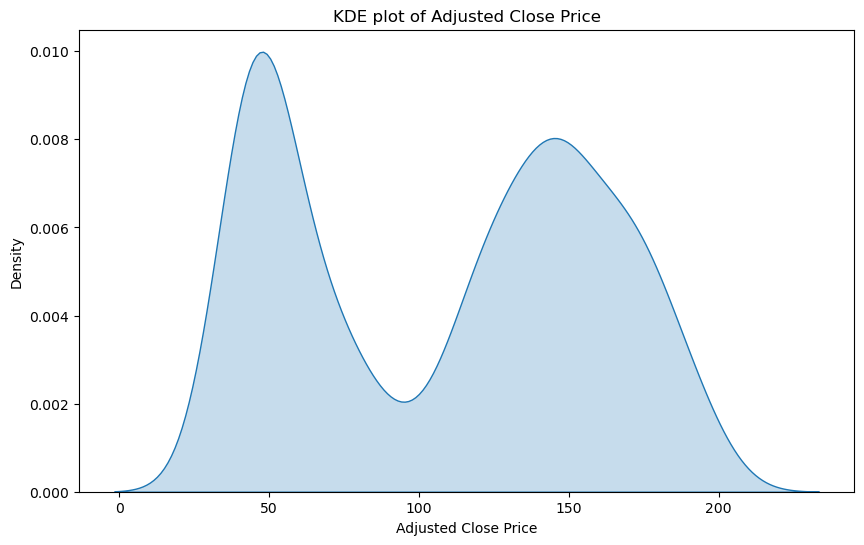

In [8]:
# KDE plot of the adjusted close price
plt.figure(figsize=(10,6))
sns.kdeplot(stock_data['Adj Close'], shade=True)
plt.title('KDE plot of Adjusted Close Price')
plt.xlabel('Adjusted Close Price')
plt.ylabel('Density')
plt.show()

# Models

In [9]:
# Load the dataset
test_data, train_data, index_data = InitDataset.get_test_train_data()

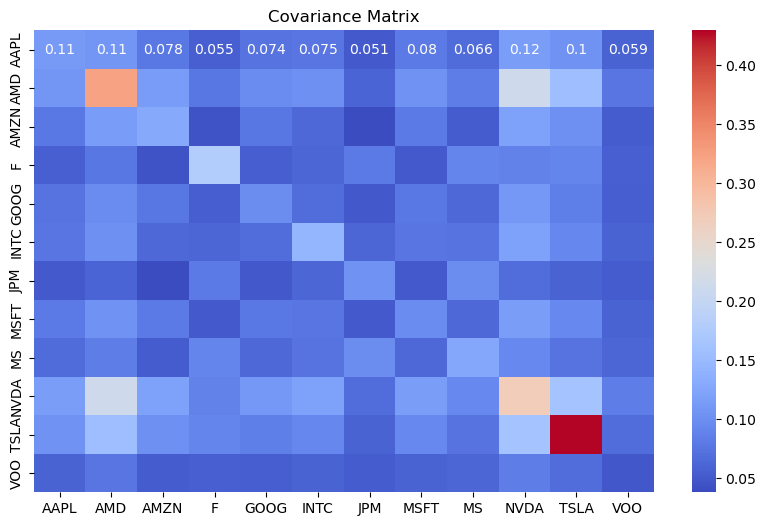

In [10]:
portfolio_returns = train_data.pct_change()
covariance = portfolio_returns.cov()*252
# Heatmap of the covariance matrix
plt.figure(figsize=(10,6))
sns.heatmap(covariance, annot=True, cmap='coolwarm')
plt.title('Covariance Matrix')
plt.show()

In [11]:
# Allocate equal weights to all stocks

weights = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
portfolio_variance = np.transpose(weights) @ covariance @ weights
print(f'Portfolio Variance: {portfolio_variance}')

Portfolio Variance: 0.794052261265668


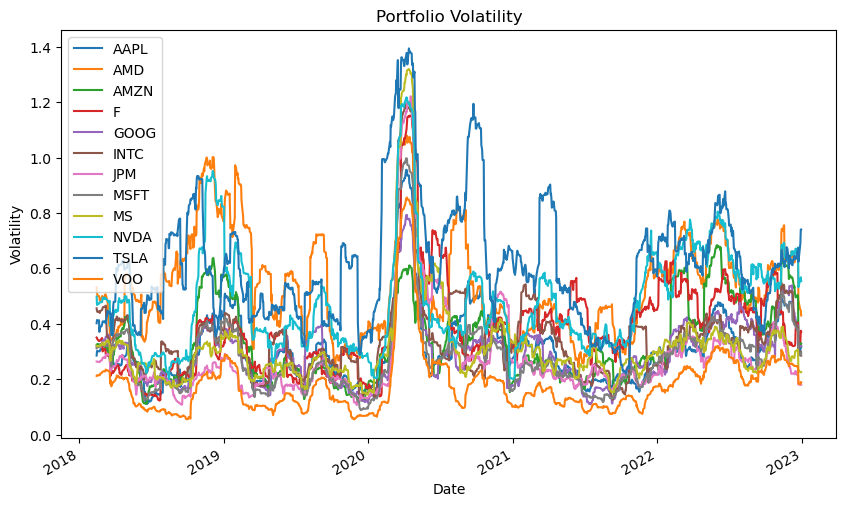

In [12]:
# Calculate the portfolio volatility

windowed = portfolio_returns.rolling(30)
volatility = windowed.std() * np.sqrt(252)
volatility.plot(figsize=(10,6))
plt.title('Portfolio Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

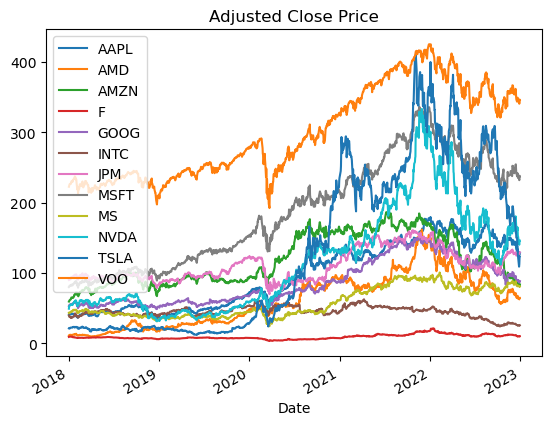

In [13]:
# Plot the adjusted close price
train_data.plot(title='Adjusted Close Price')
plt.show()

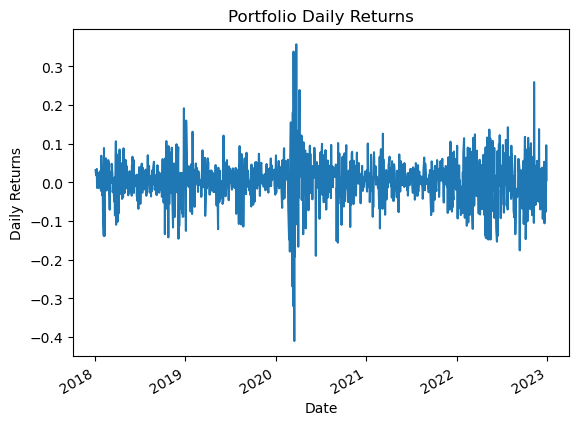

In [14]:
# Calculate the daily returns
asset_returns = train_data.pct_change()
portfolio_returns = asset_returns@weights

# Plot the daily returns
portfolio_returns.plot().set_ylabel('Daily Returns')
plt.title('Portfolio Daily Returns')
plt.show()

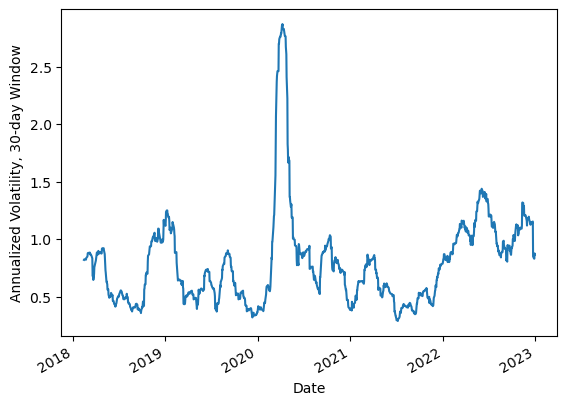

In [15]:
# Calculate the 30-day rolling window of portfolio returns
returns_windowed= portfolio_returns.rolling(30)

# Compute the annualized volatility series
volatility_series = returns_windowed.std()*np.sqrt(252)

# Plot the portfolio volatility
volatility_series.plot().set_ylabel("Annualized Volatility, 30-day Window")
plt.show()

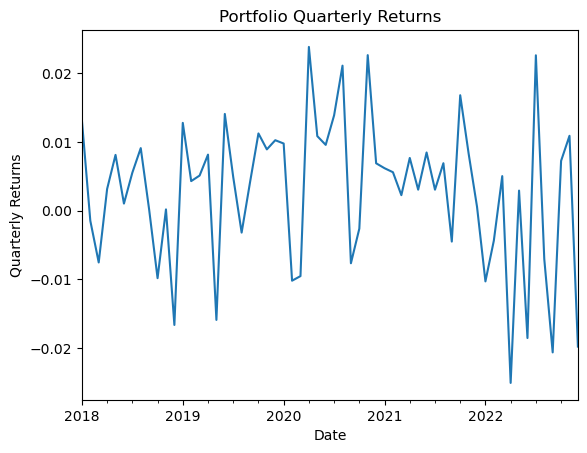

In [16]:
# Convert daily returns to quarterly average returns
quarterly_returns = portfolio_returns.resample('MS').mean().dropna()
quarterly_returns.plot().set_ylabel("Quarterly Returns")
plt.title('Portfolio Quarterly Returns')
plt.show()

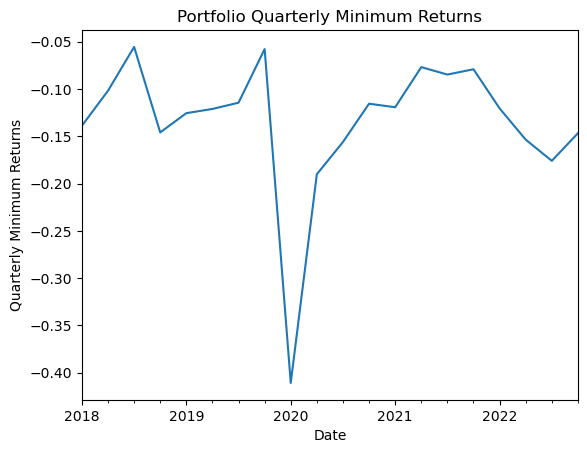

In [17]:
# Transform daily portfolio_returns returns into quarterly minimum returns
quarterly_min_returns = portfolio_returns.resample('Q').min().dropna()
quarterly_min_returns.plot().set_ylabel("Quarterly Minimum Returns")
plt.title('Portfolio Quarterly Minimum Returns')
plt.show()

## Kmeans - Volatility (Daily)


For k=3:
Silhouette Score: 0.5144
Davies-Bouldin Index: 0.3113
Calinski-Harabasz Index: 39.2406
Suggested Stocks without PCA for k=3: ['JPM', 'NVDA', 'VOO']


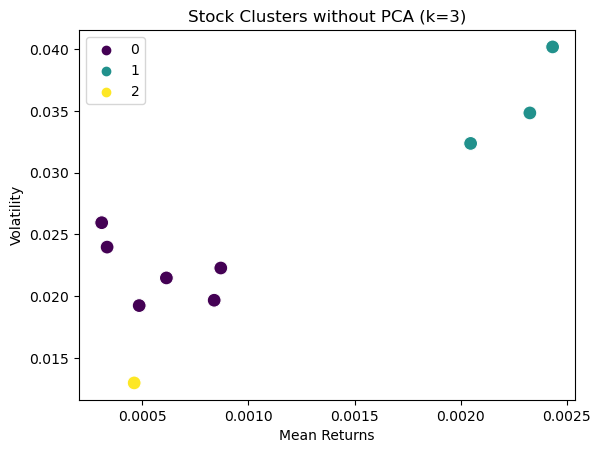


For k=4:
Silhouette Score: 0.5314
Davies-Bouldin Index: 0.3774
Calinski-Harabasz Index: 40.6486
Suggested Stocks without PCA for k=4: ['INTC', 'NVDA', 'JPM', 'VOO']


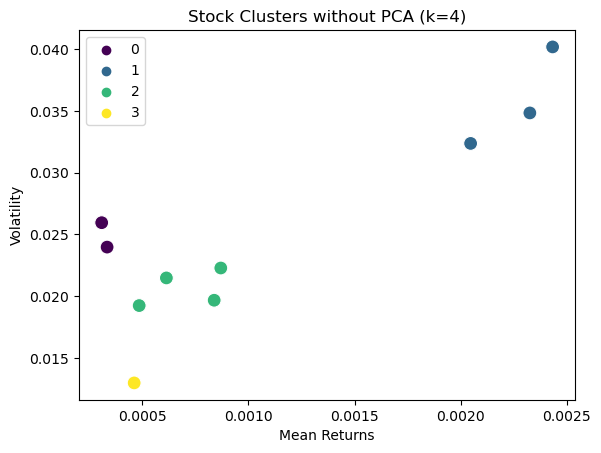


For k=5:
Silhouette Score: 0.4064
Davies-Bouldin Index: 0.3579
Calinski-Harabasz Index: 61.0149
Suggested Stocks without PCA for k=5: ['INTC', 'NVDA', 'JPM', 'VOO', 'TSLA']


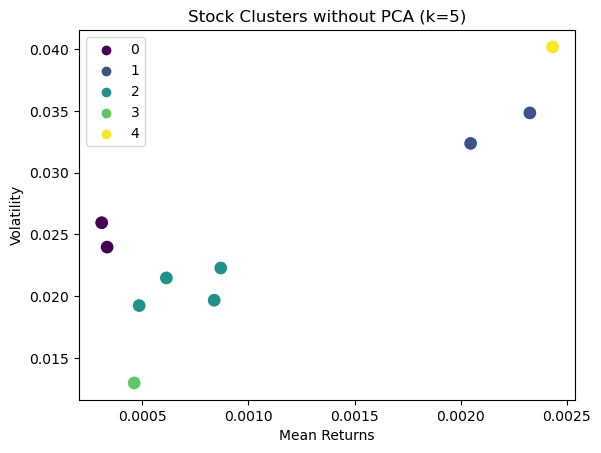


For k=6:
Silhouette Score: 0.3010
Davies-Bouldin Index: 0.4773
Calinski-Harabasz Index: 62.4895
Suggested Stocks without PCA for k=6: ['NVDA', 'JPM', 'TSLA', 'VOO', 'INTC', 'GOOG']


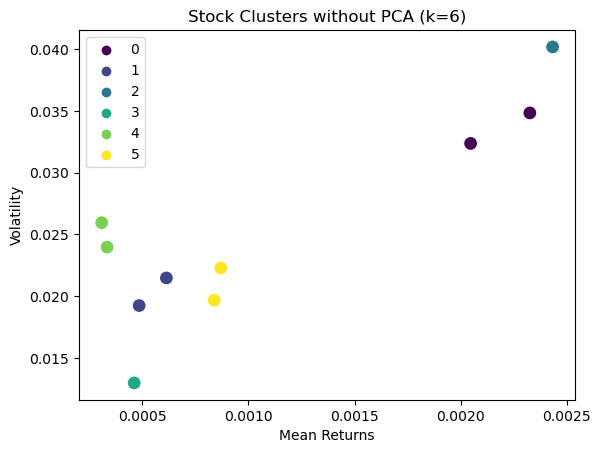


For k=7:
Silhouette Score: 0.2103
Davies-Bouldin Index: 0.3632
Calinski-Harabasz Index: 69.4110
Suggested Stocks without PCA for k=7: ['GOOG', 'NVDA', 'TSLA', 'INTC', 'VOO', 'JPM', 'AMD']


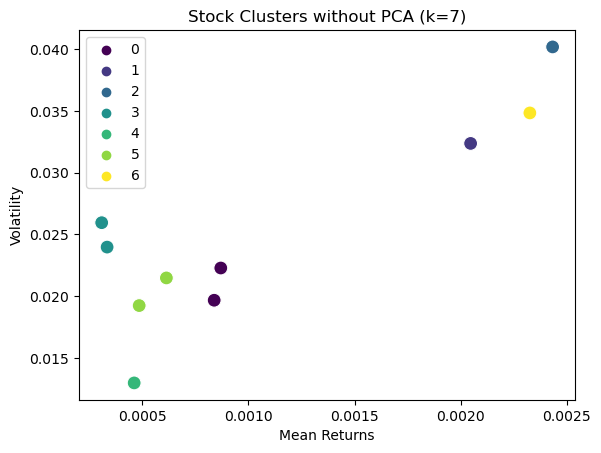


For k=8:
Silhouette Score: 0.1488
Davies-Bouldin Index: 0.2540
Calinski-Harabasz Index: 65.9071
Suggested Stocks without PCA for k=8: ['INTC', 'AMD', 'JPM', 'VOO', 'GOOG', 'TSLA', 'NVDA', 'AMZN']


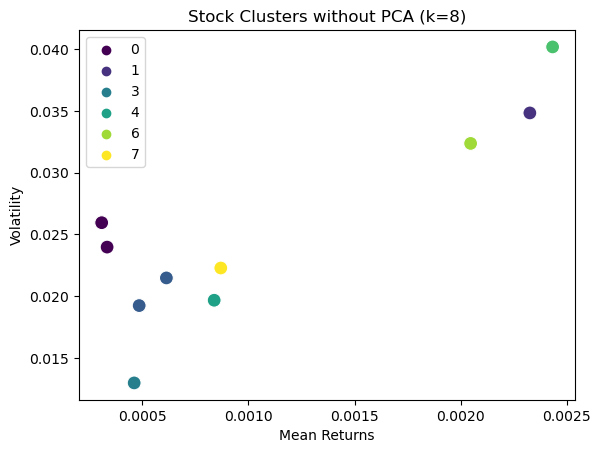


For k=9:
Silhouette Score: 0.1087
Davies-Bouldin Index: 0.1265
Calinski-Harabasz Index: 76.6627
Suggested Stocks without PCA for k=9: ['INTC', 'AMD', 'JPM', 'VOO', 'GOOG', 'TSLA', 'NVDA', 'AMZN', 'MS']


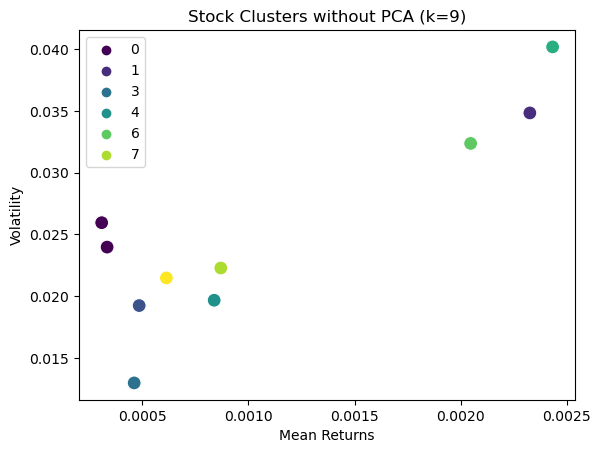

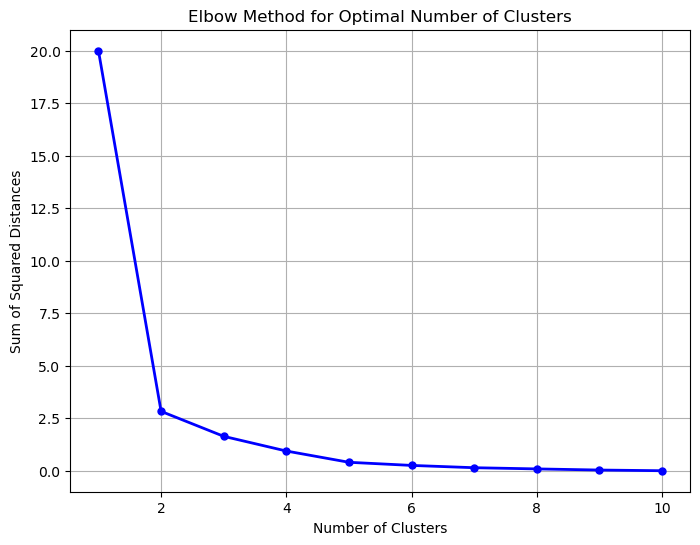

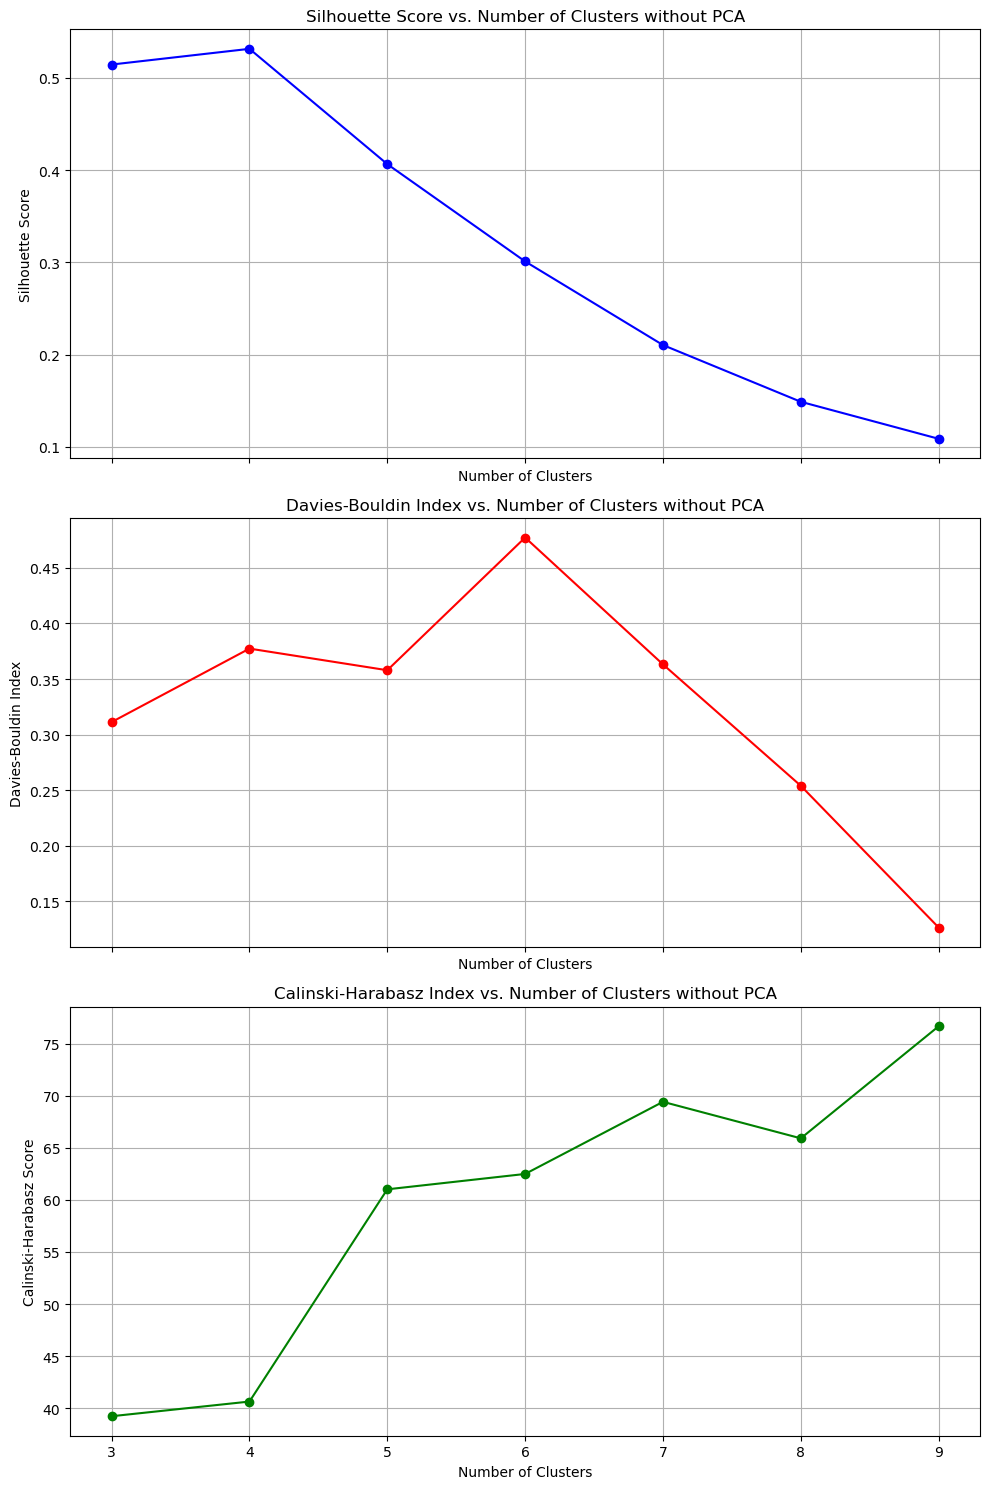


Clustering with PCA

For k=3:
Silhouette Score: 0.5948
Davies-Bouldin Index: 0.4931
Calinski-Harabasz Index: 16.5227
Suggested Stocks with PCA for k=3: ['INTC', 'VOO', 'NVDA']


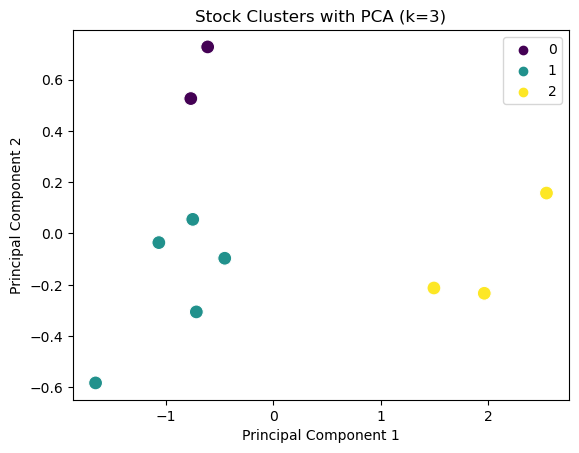


For k=4:
Silhouette Score: 0.5294
Davies-Bouldin Index: 0.3735
Calinski-Harabasz Index: 20.6683
Suggested Stocks with PCA for k=4: ['INTC', 'JPM', 'NVDA', 'VOO']


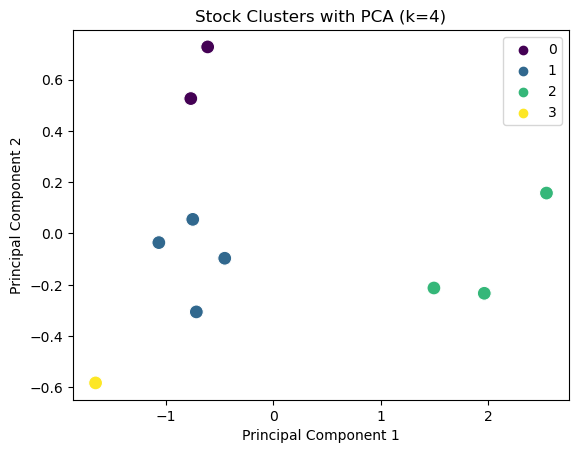


For k=5:
Silhouette Score: 0.5018
Davies-Bouldin Index: 0.2708
Calinski-Harabasz Index: 28.9630
Suggested Stocks with PCA for k=5: ['INTC', 'JPM', 'NVDA', 'VOO', 'TSLA']


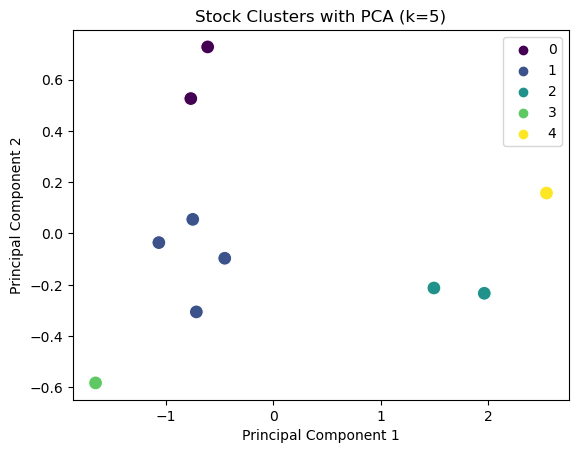


For k=6:
Silhouette Score: 0.4048
Davies-Bouldin Index: 0.2447
Calinski-Harabasz Index: 39.2558
Suggested Stocks with PCA for k=6: ['NVDA', 'JPM', 'INTC', 'VOO', 'TSLA', 'GOOG']


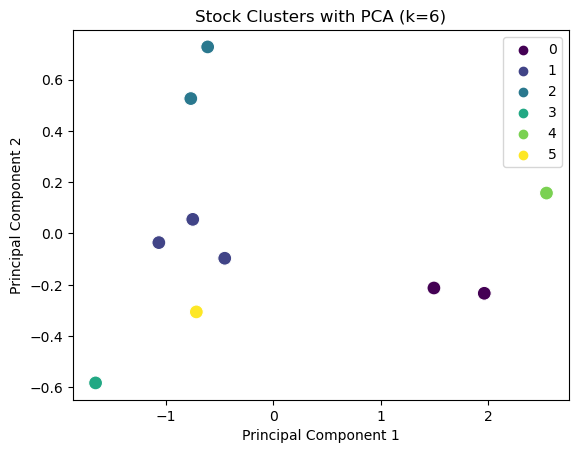


For k=7:
Silhouette Score: 0.2690
Davies-Bouldin Index: 0.2082
Calinski-Harabasz Index: 40.2120
Suggested Stocks with PCA for k=7: ['GOOG', 'F', 'TSLA', 'NVDA', 'JPM', 'VOO', 'INTC']


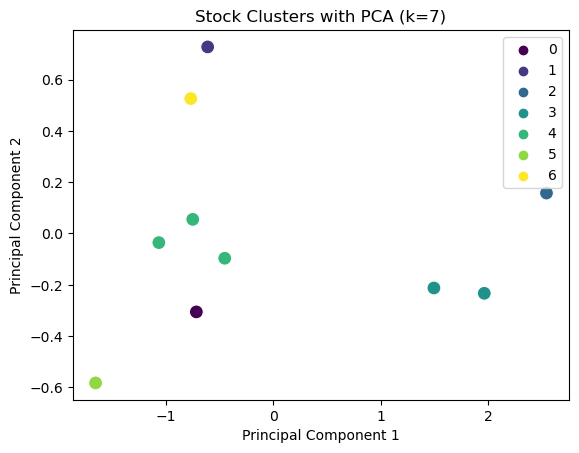


For k=8:
Silhouette Score: 0.1988
Davies-Bouldin Index: 0.1977
Calinski-Harabasz Index: 48.6071
Suggested Stocks with PCA for k=8: ['F', 'AMZN', 'NVDA', 'VOO', 'TSLA', 'GOOG', 'JPM', 'INTC']


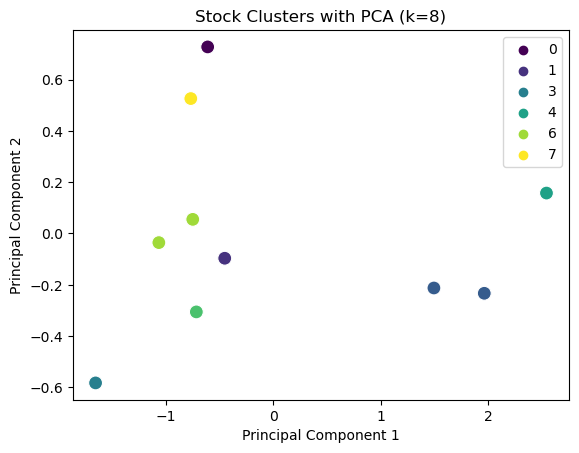


For k=9:
Silhouette Score: 0.0571
Davies-Bouldin Index: 0.1665
Calinski-Harabasz Index: 44.1250
Suggested Stocks with PCA for k=9: ['F', 'AMZN', 'NVDA', 'VOO', 'TSLA', 'GOOG', 'JPM', 'INTC', 'AMD']


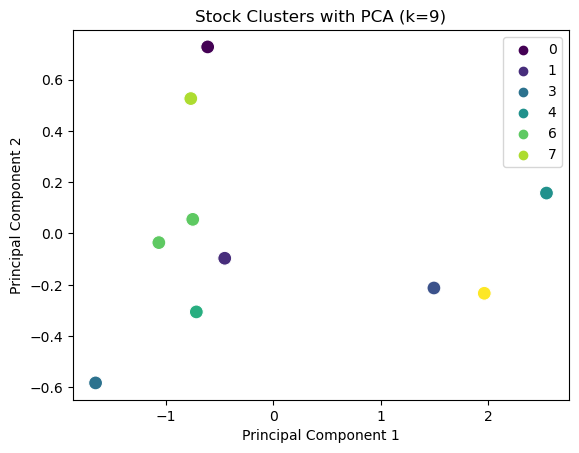

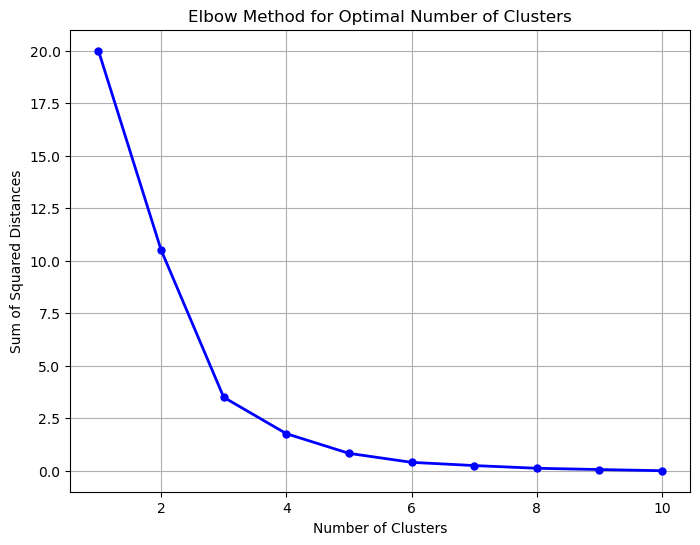

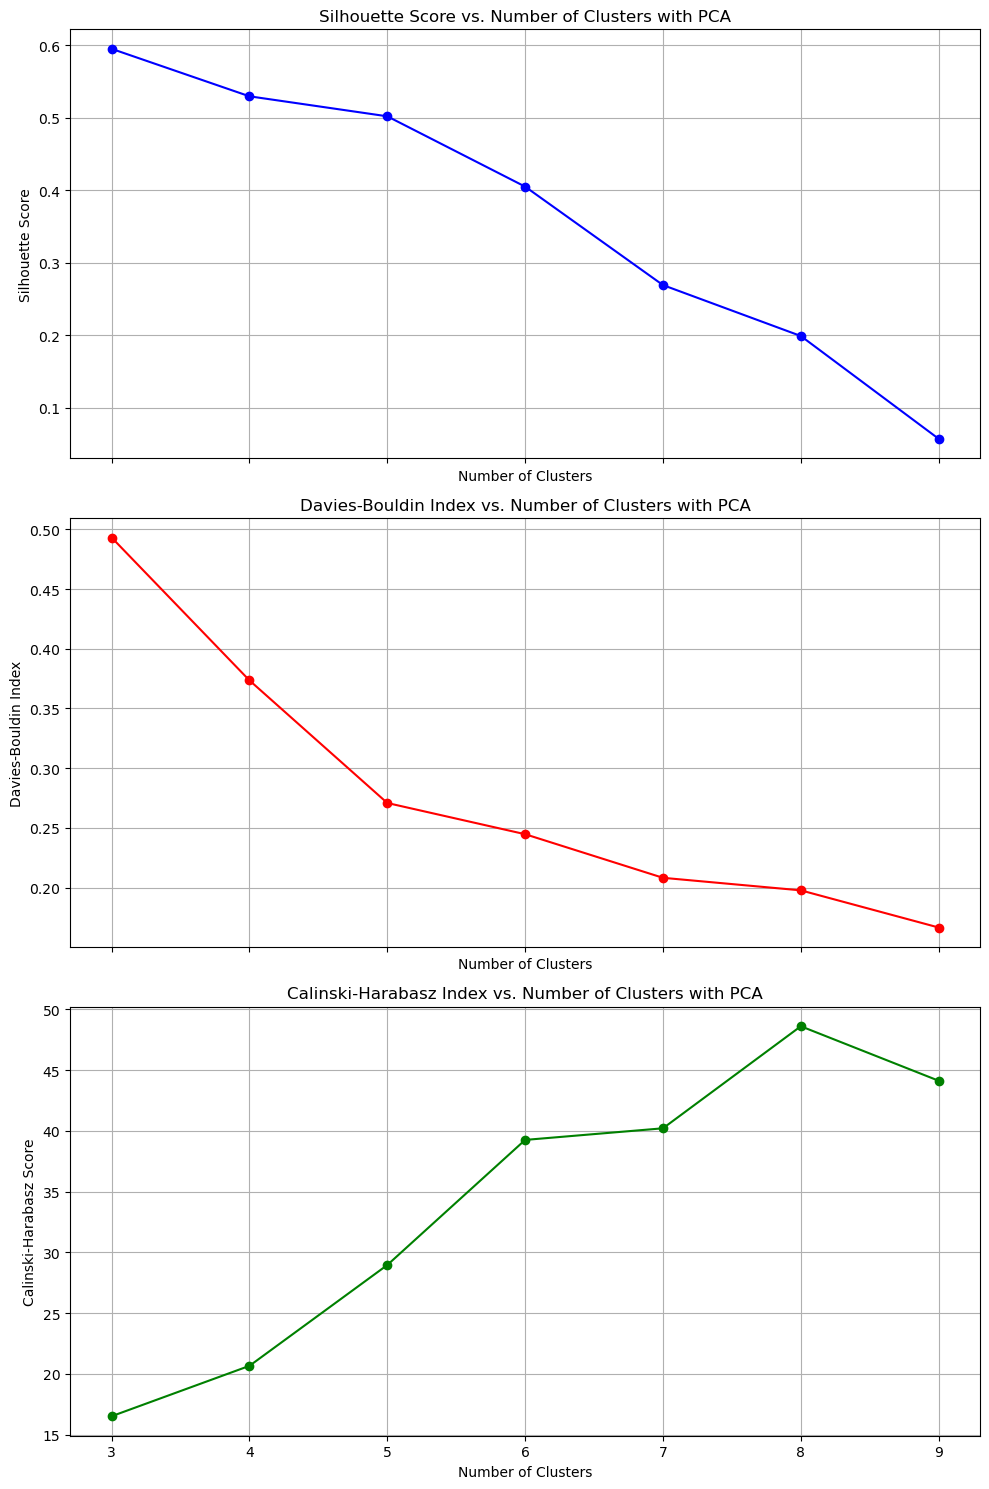

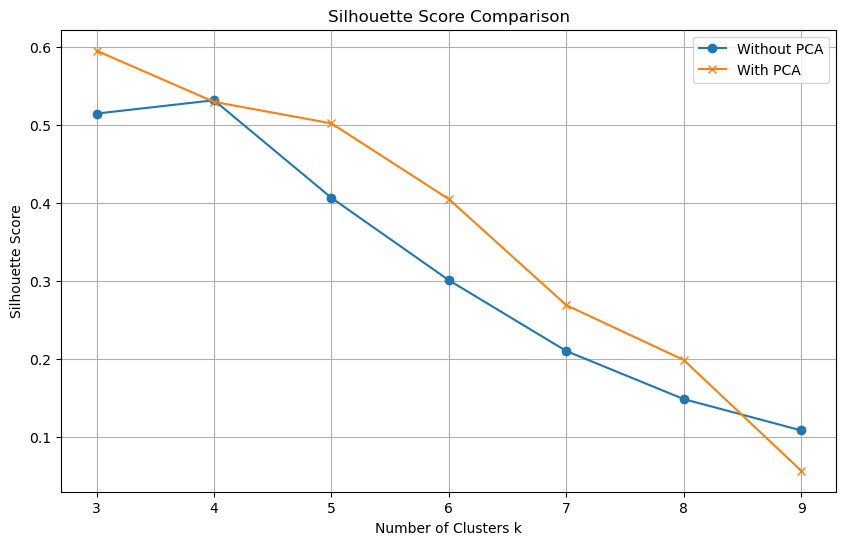

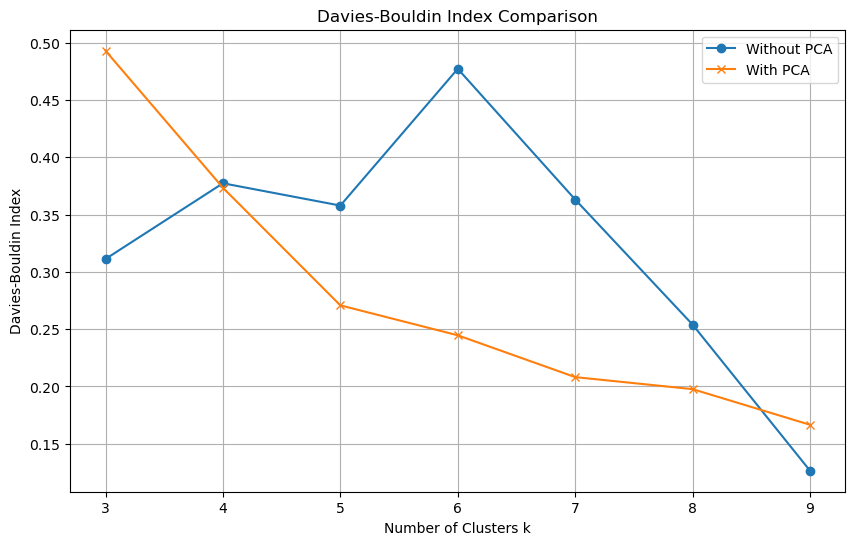

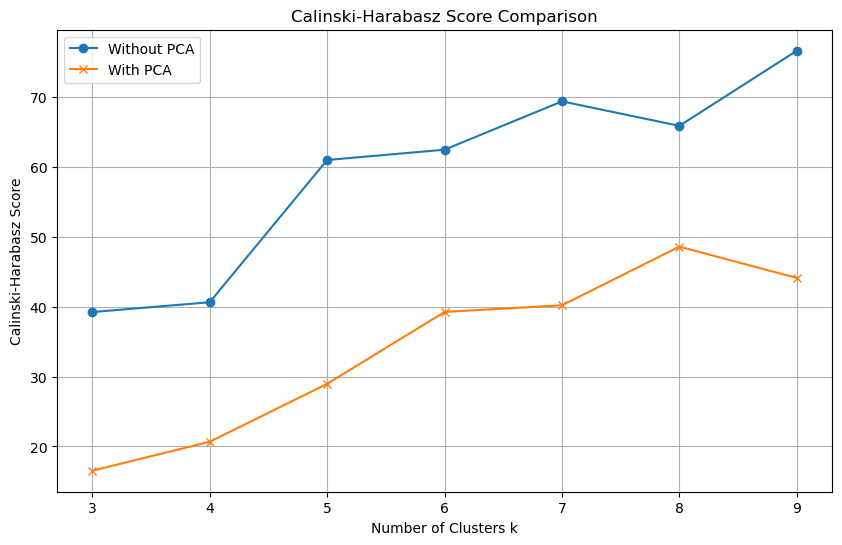

In [18]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_stock_data()
kmeans.volatility_feature_engineering()

cluster_range = range(3, 10)
kmeans.volatility_clustering_without_pca(range_n_clusters=cluster_range)
kmeans.plot_elbow_method()
kmeans.plot_metrics_without_pca()
kmeans.volatility_clustering_with_pca(range_n_clusters=cluster_range)
kmeans.plot_elbow_method()
kmeans.plot_metrics_pca()

kmeans.plot_metrics()

## Kmeans - Quarterly data


Without PCA - n_clusters=4, Silhouette Score: 0.40, Davies-Bouldin Index: 0.77, Calinski-Harabasz Index: 21.78


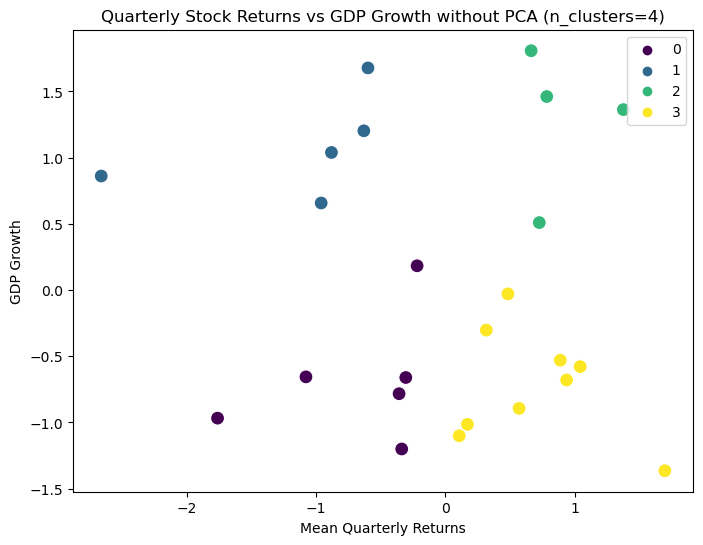

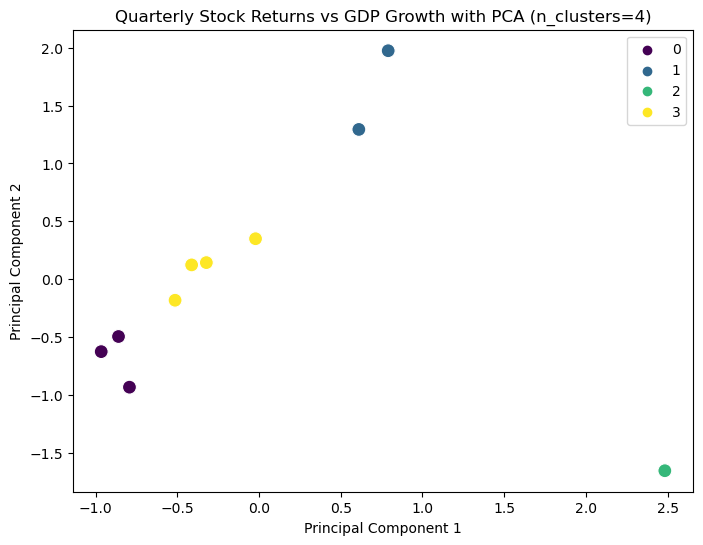

With PCA - n_clusters=4, Silhouette Score: 0.55, Davies-Bouldin Index: 0.31, Calinski-Harabasz Index: 60.28


In [19]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_stock_data()
kmeans.gdp_quarterly_feature_engineering()

kmeans.gdp_quarterly_clustering_without_pca()
kmeans.gdp_quarterly_clustering_pca()


## Kmeans Balance dataset

Without PCA - n_clusters=4, Silhouette Score: 0.42, Davies-Bouldin Index: 0.69, Calinski-Harabasz Index: 22.07


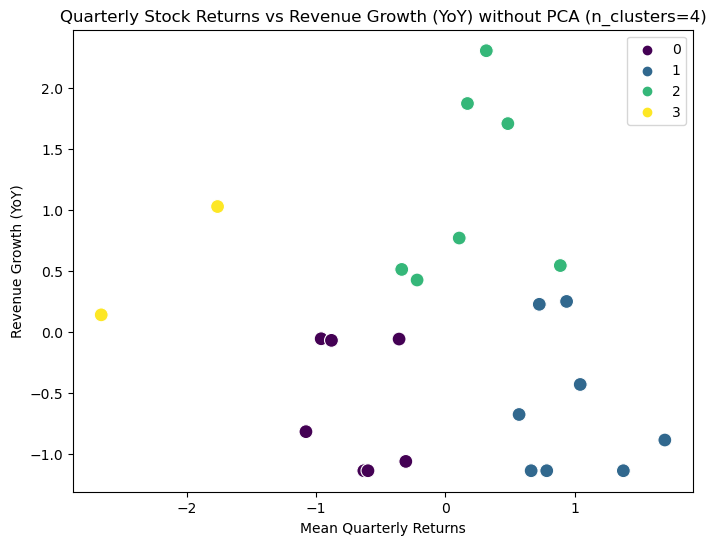

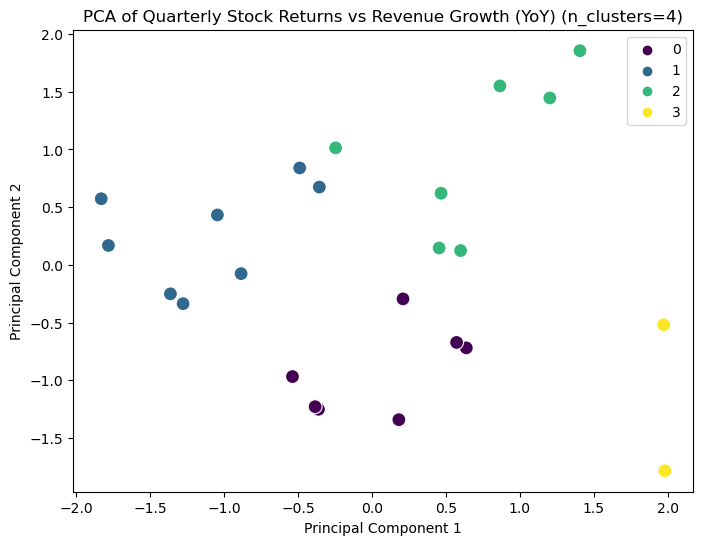

With PCA - n_clusters=4, Silhouette Score: 0.42, Davies-Bouldin Index: 0.69, Calinski-Harabasz Index: 22.07
Without PCA - n_clusters=4, Silhouette Score: 0.45, Davies-Bouldin Index: 0.58, Calinski-Harabasz Index: 26.94


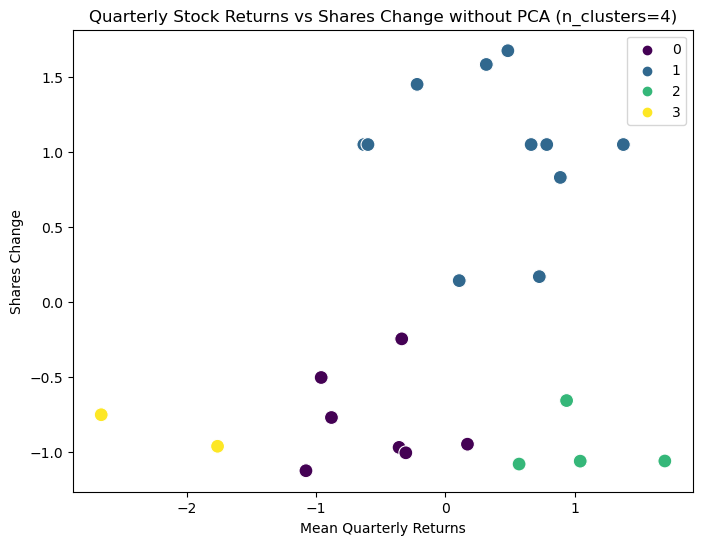

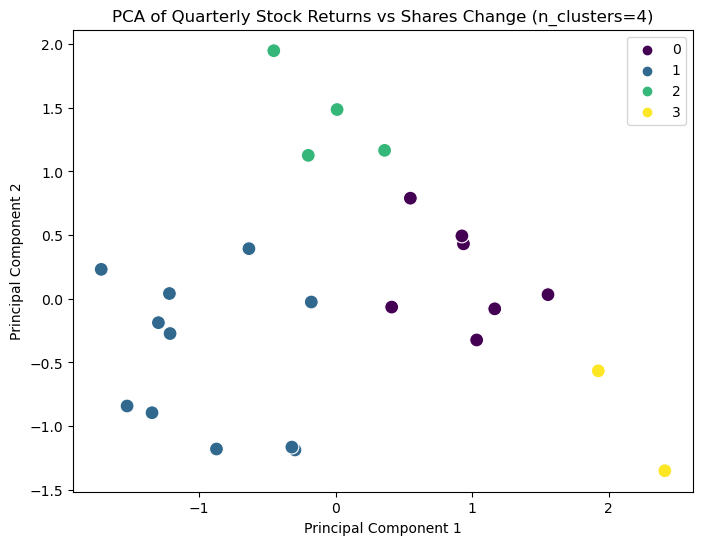

With PCA - n_clusters=4, Silhouette Score: 0.45, Davies-Bouldin Index: 0.58, Calinski-Harabasz Index: 26.94
Without PCA - n_clusters=4, Silhouette Score: 0.38, Davies-Bouldin Index: 0.80, Calinski-Harabasz Index: 21.69


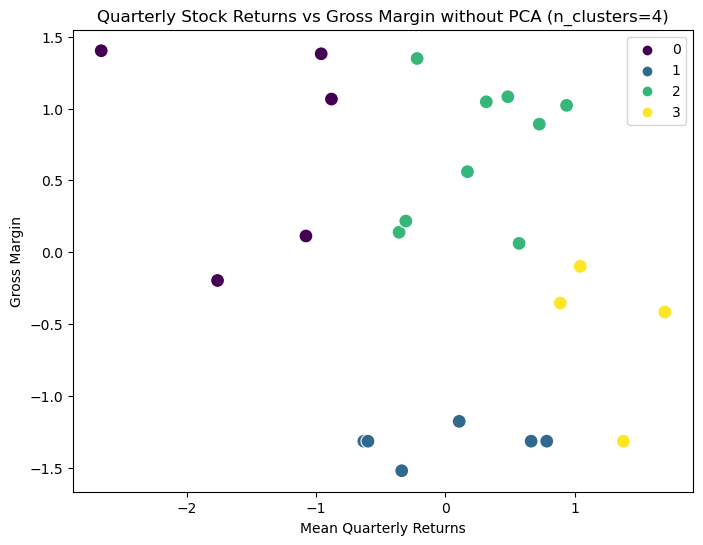

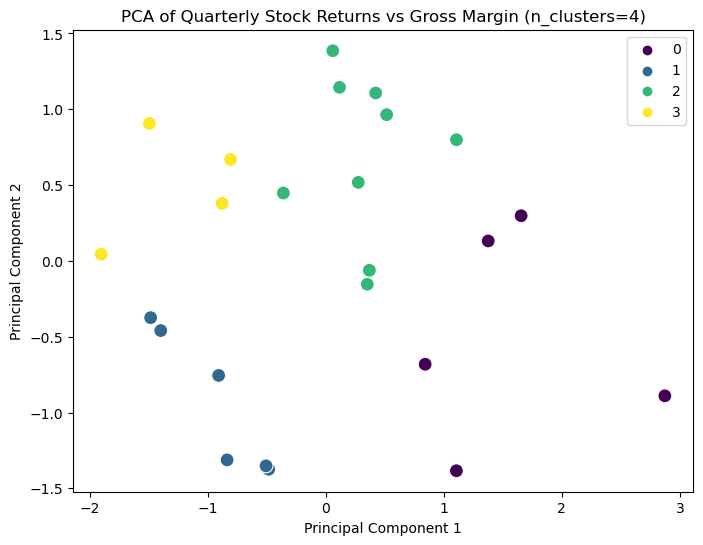

With PCA - n_clusters=4, Silhouette Score: 0.38, Davies-Bouldin Index: 0.80, Calinski-Harabasz Index: 21.69
Without PCA - n_clusters=4, Silhouette Score: 0.39, Davies-Bouldin Index: 0.75, Calinski-Harabasz Index: 20.79


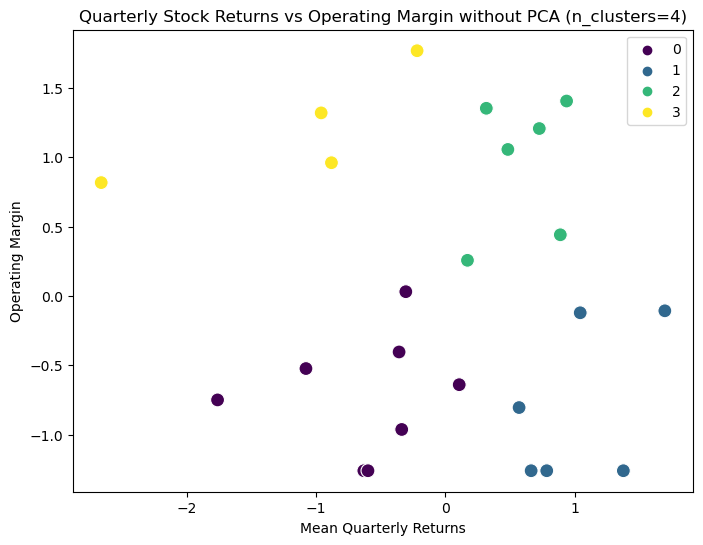

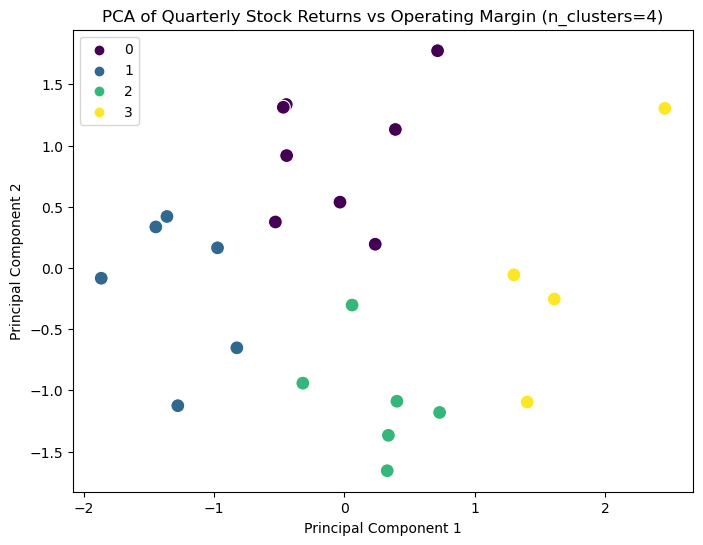

With PCA - n_clusters=4, Silhouette Score: 0.39, Davies-Bouldin Index: 0.75, Calinski-Harabasz Index: 20.79
Without PCA - n_clusters=4, Silhouette Score: 0.44, Davies-Bouldin Index: 0.69, Calinski-Harabasz Index: 24.58


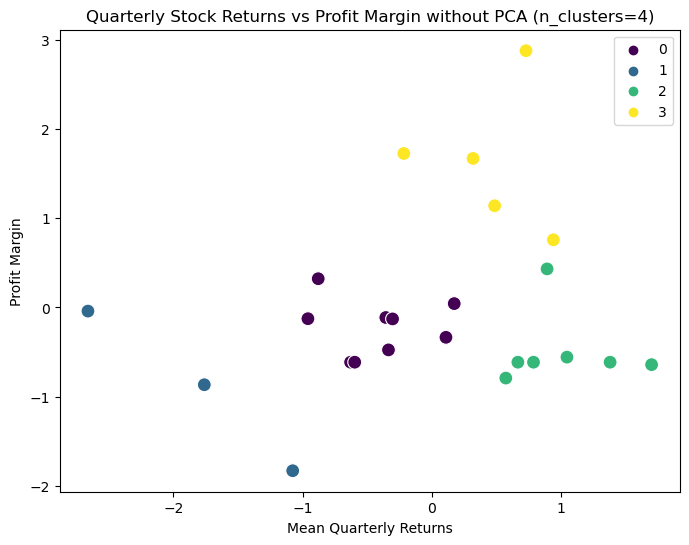

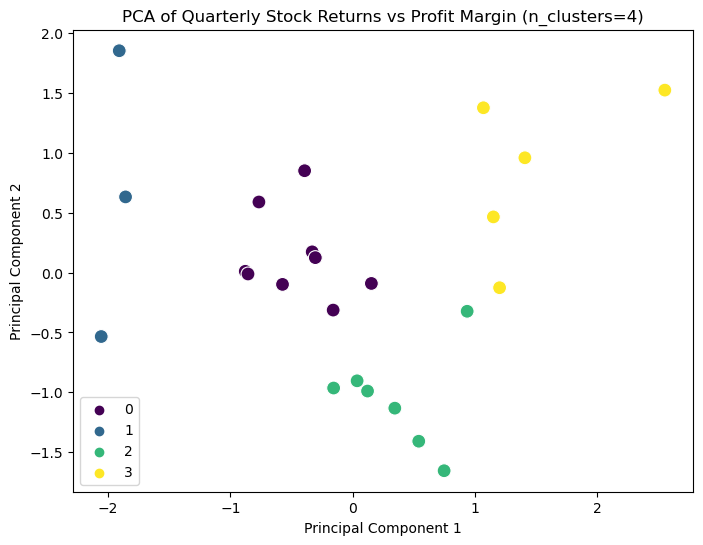

With PCA - n_clusters=4, Silhouette Score: 0.44, Davies-Bouldin Index: 0.69, Calinski-Harabasz Index: 24.58
Without PCA - n_clusters=4, Silhouette Score: 0.36, Davies-Bouldin Index: 0.71, Calinski-Harabasz Index: 16.27


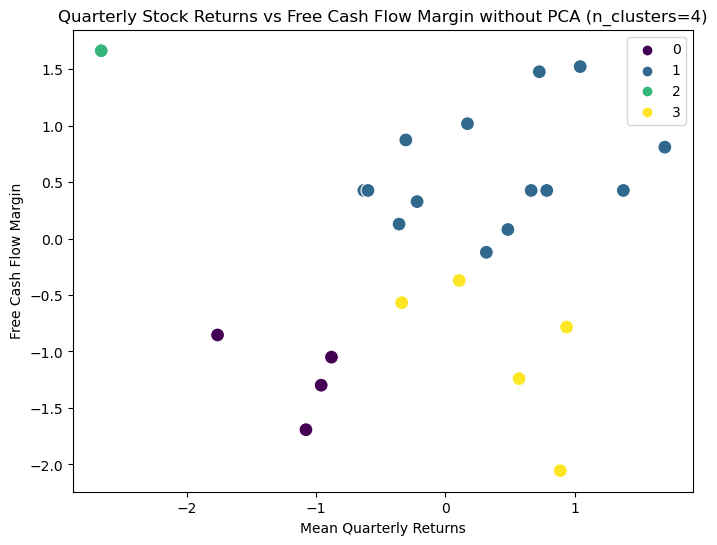

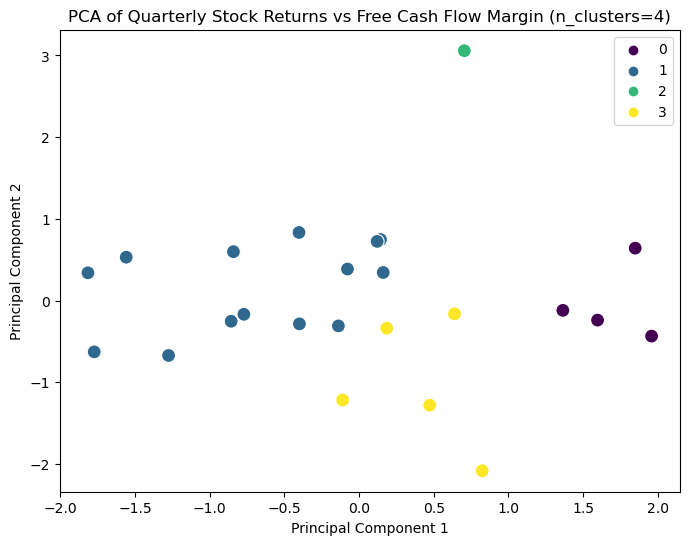

With PCA - n_clusters=4, Silhouette Score: 0.36, Davies-Bouldin Index: 0.71, Calinski-Harabasz Index: 16.27
Without PCA - n_clusters=4, Silhouette Score: 0.46, Davies-Bouldin Index: 0.67, Calinski-Harabasz Index: 28.15


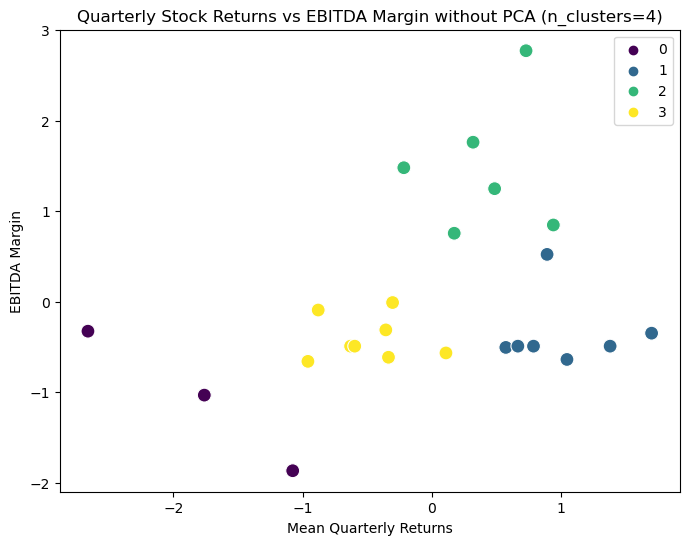

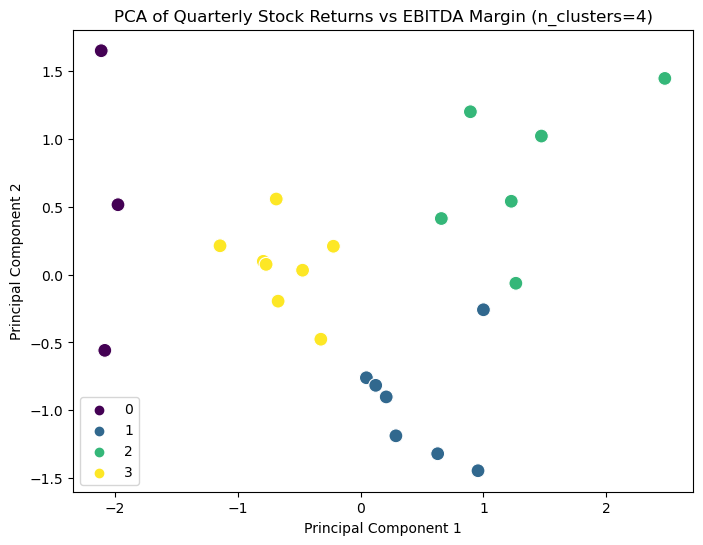

With PCA - n_clusters=4, Silhouette Score: 0.46, Davies-Bouldin Index: 0.67, Calinski-Harabasz Index: 28.15
Without PCA - n_clusters=4, Silhouette Score: 0.44, Davies-Bouldin Index: 0.67, Calinski-Harabasz Index: 23.91


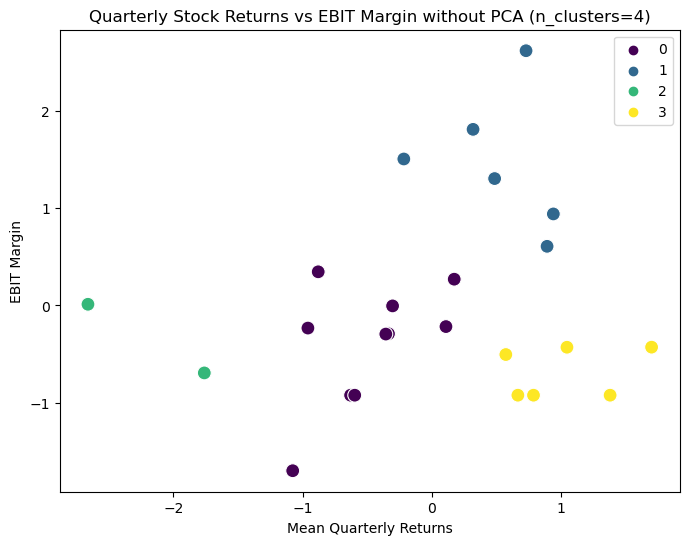

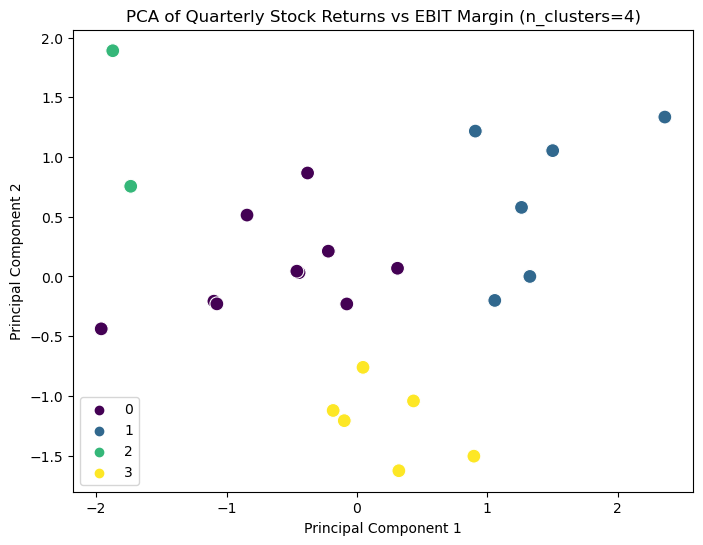

With PCA - n_clusters=4, Silhouette Score: 0.44, Davies-Bouldin Index: 0.67, Calinski-Harabasz Index: 23.91
Without PCA - n_clusters=4, Silhouette Score: 0.41, Davies-Bouldin Index: 0.70, Calinski-Harabasz Index: 23.74


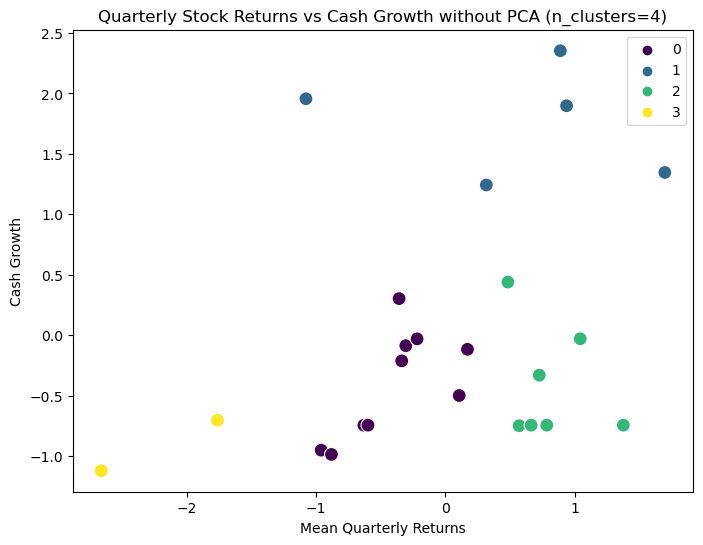

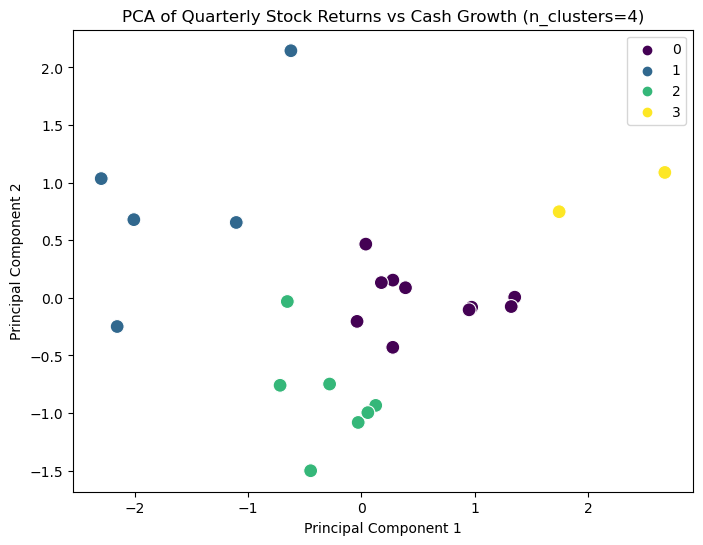

With PCA - n_clusters=4, Silhouette Score: 0.41, Davies-Bouldin Index: 0.70, Calinski-Harabasz Index: 23.74
Without PCA - n_clusters=4, Silhouette Score: 0.49, Davies-Bouldin Index: 0.63, Calinski-Harabasz Index: 30.89


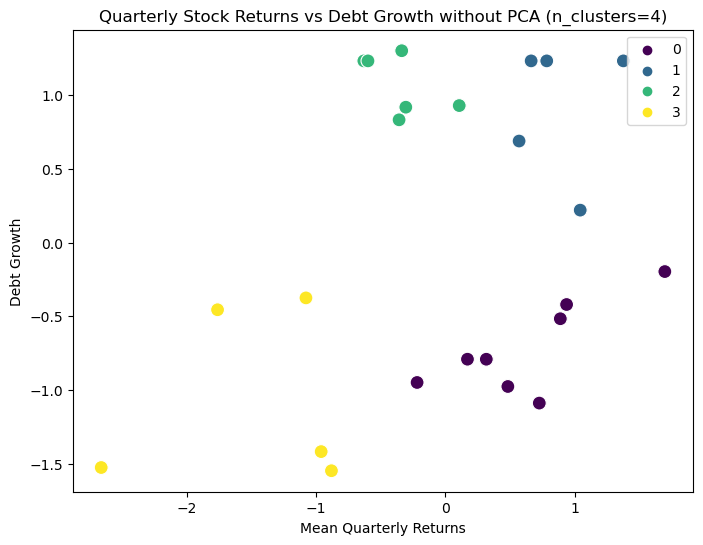

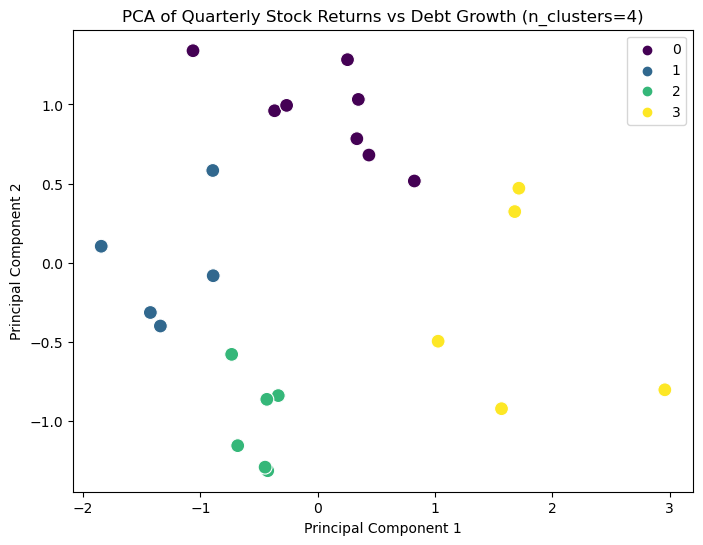

With PCA - n_clusters=4, Silhouette Score: 0.49, Davies-Bouldin Index: 0.63, Calinski-Harabasz Index: 30.89


In [20]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_stock_data()
kmeans.quarterly_feature_engineering(n_clusters=4)

## Kmeans - Economic data 

Without PCA - REAINTRATREARAT10Y: n_clusters=4, Silhouette Score: 0.40, Davies-Bouldin Index: 0.81, Calinski-Harabasz Index: 60.05


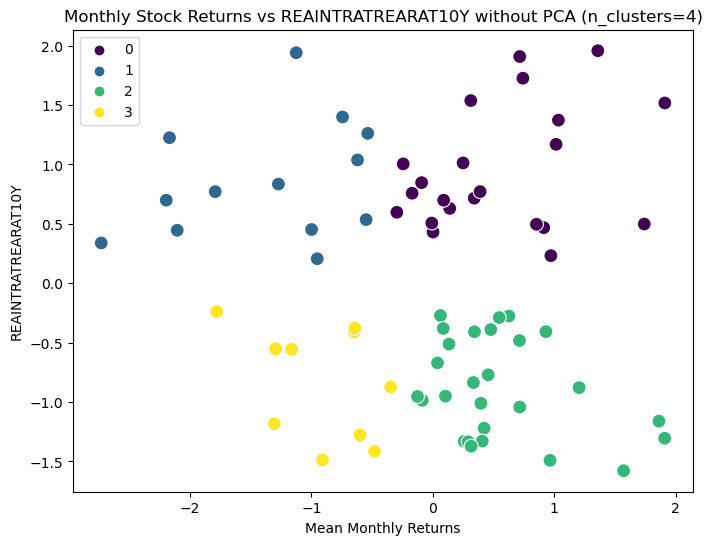

Without PCA - MEDCPIM158SFRBCLE: n_clusters=4, Silhouette Score: 0.40, Davies-Bouldin Index: 0.85, Calinski-Harabasz Index: 59.42


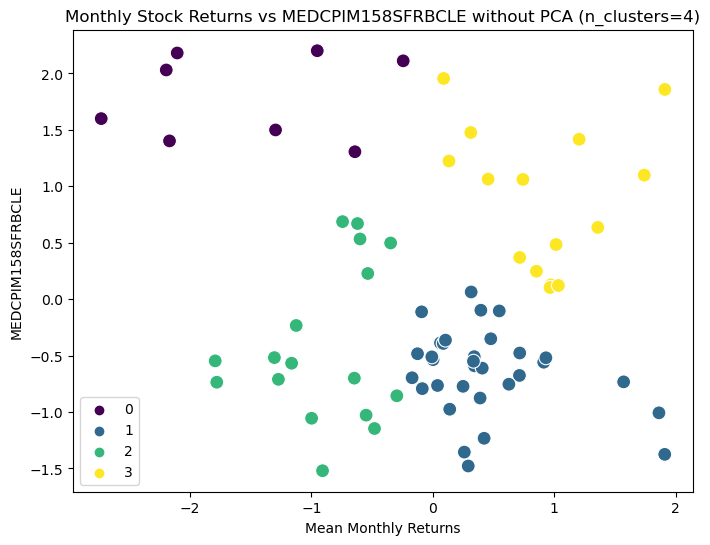

Without PCA - PSAVERT: n_clusters=4, Silhouette Score: 0.35, Davies-Bouldin Index: 0.84, Calinski-Harabasz Index: 63.66


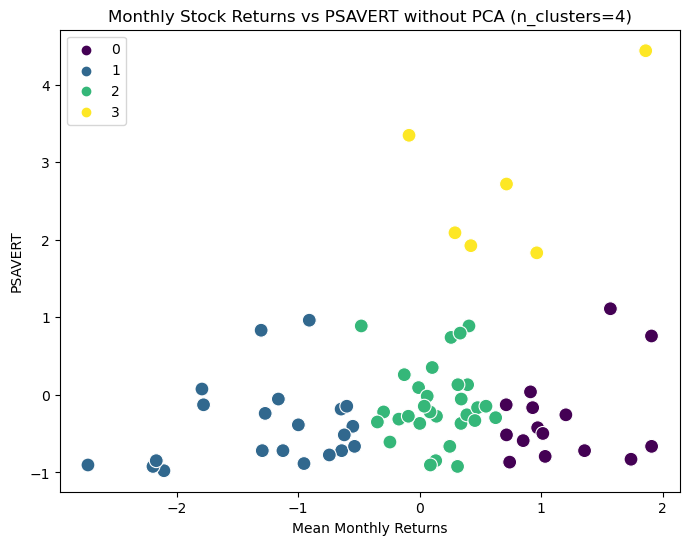

Without PCA - UNRATE: n_clusters=4, Silhouette Score: 0.48, Davies-Bouldin Index: 0.73, Calinski-Harabasz Index: 78.83


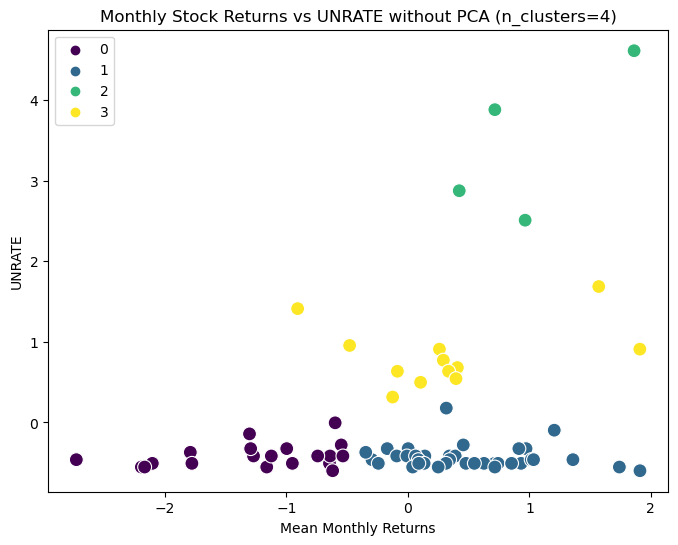

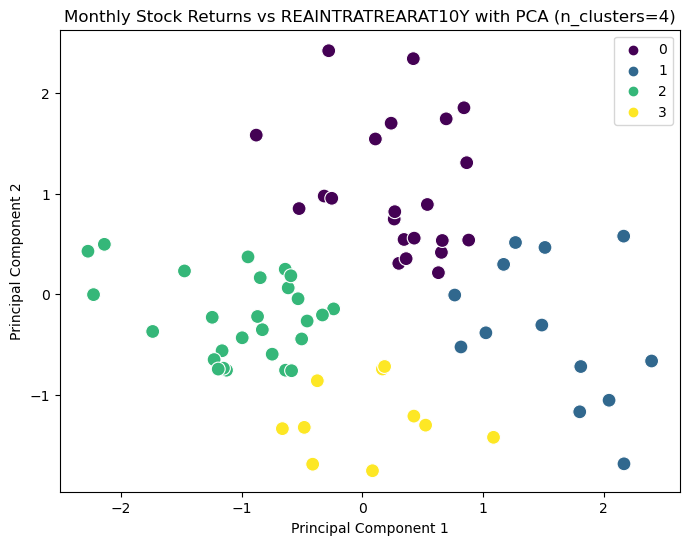

With PCA - REAINTRATREARAT10Y: n_clusters=4, Silhouette Score: 0.40, Davies-Bouldin Index: 0.81, Calinski-Harabasz Index: 60.05


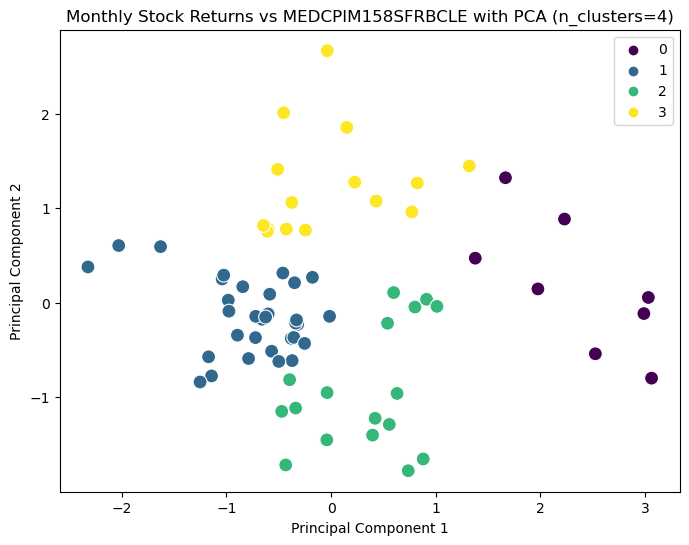

With PCA - MEDCPIM158SFRBCLE: n_clusters=4, Silhouette Score: 0.40, Davies-Bouldin Index: 0.85, Calinski-Harabasz Index: 59.42


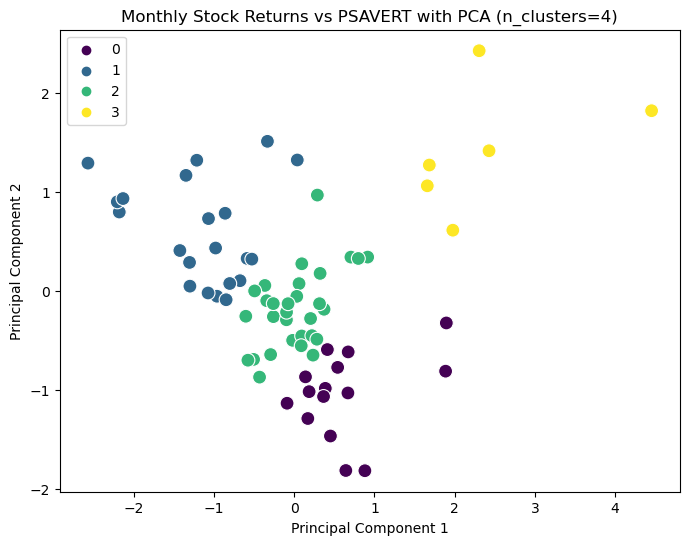

With PCA - PSAVERT: n_clusters=4, Silhouette Score: 0.35, Davies-Bouldin Index: 0.84, Calinski-Harabasz Index: 63.66


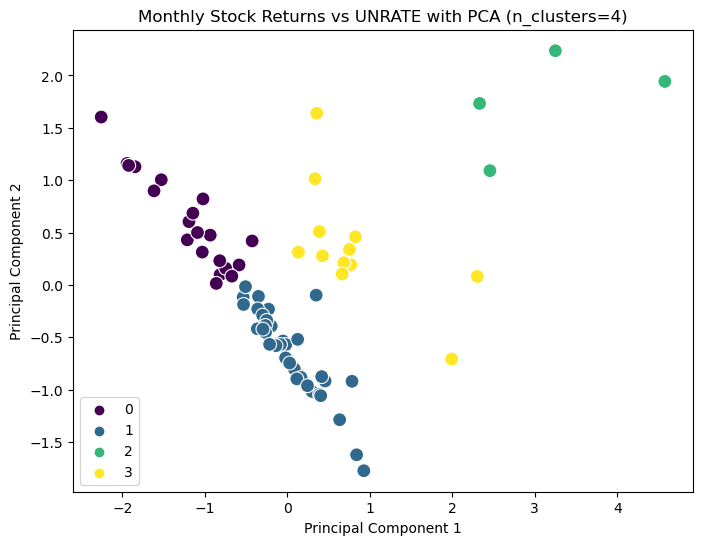

With PCA - UNRATE: n_clusters=4, Silhouette Score: 0.48, Davies-Bouldin Index: 0.73, Calinski-Harabasz Index: 78.83


In [21]:
from src.mykmeans import MyKMeans

kmeans = MyKMeans()
kmeans.set_econ_data()
indicators = ['REAINTRATREARAT10Y', 'MEDCPIM158SFRBCLE', 'PSAVERT', 'UNRATE']
kmeans.economic_indicator_clustering_without_pca(indictors=indicators)
kmeans.economic_indicator_clustering_pca(indictors=indicators)

## DBSCAN

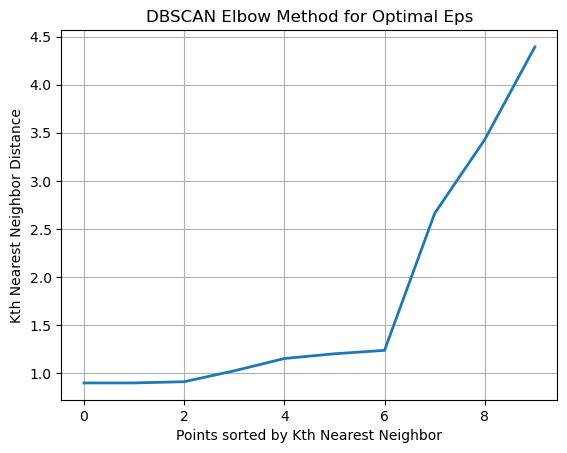

Clustering without PCA
Suggested Stocks without PCA for eps=1.25: ['NVDA', 'VOO']
Silhouette 0.5827907213397175
Davies Bouldin 0.7117793235078497
Calinski Harabasz 14.224370605389574


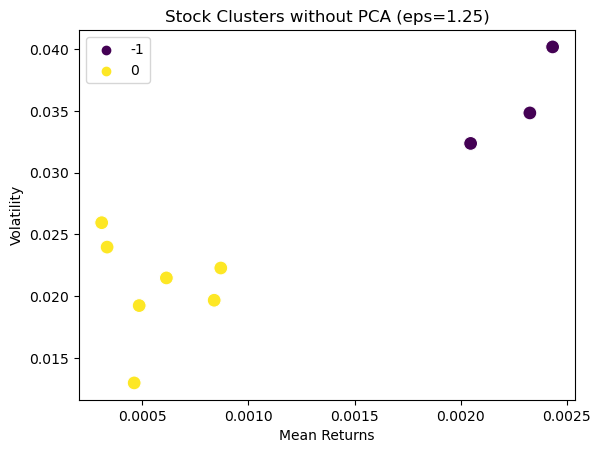

Suggested Stocks without PCA for eps=1.5: ['NVDA', 'VOO']
Silhouette 0.5827907213397175
Davies Bouldin 0.7117793235078497
Calinski Harabasz 14.224370605389574


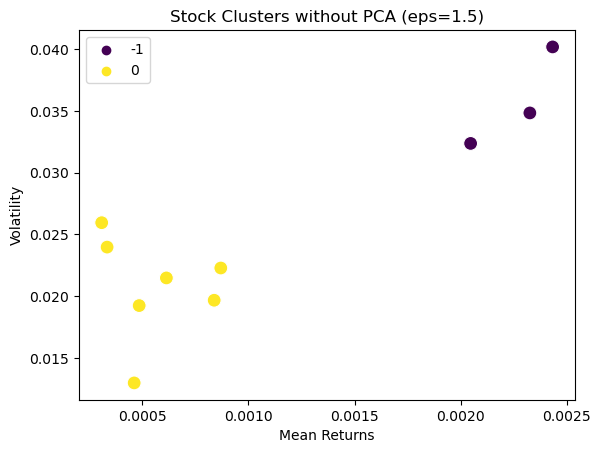

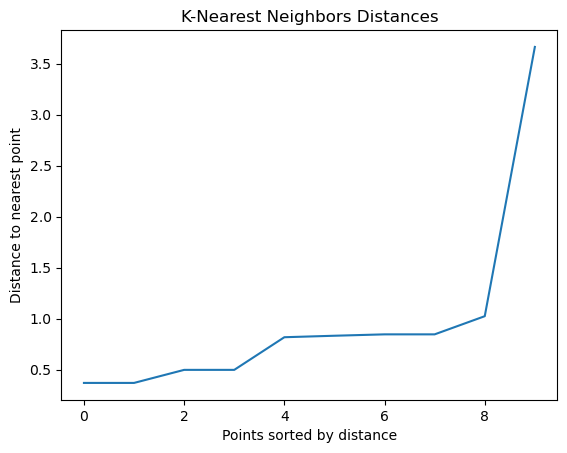

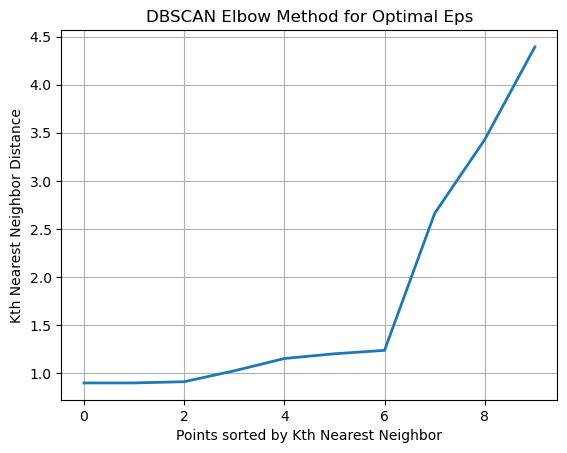

Clustering with PCA


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [22]:
dbscan = MyDBSCAN()
dbscan.set_stock_data()
dbscan.volatility_feature_engineering()
dbscan.get_elbow_plot()
dbscan.volatility_clustering_without_pca()
dbscan.get_nearest_neighbors()
dbscan.get_elbow_plot()
dbscan.volatility_clustering_with_pca()

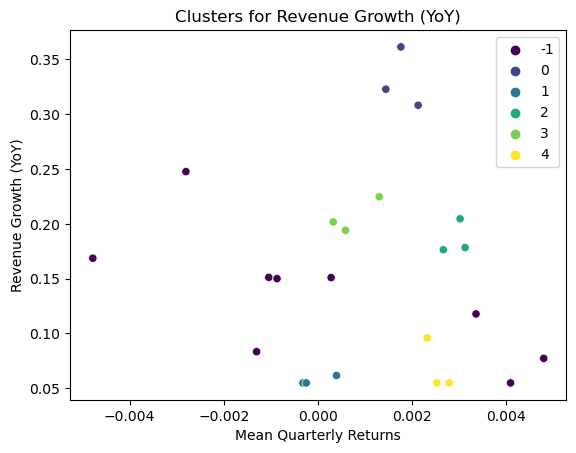

Metrics for Revenue Growth (YoY) - Silhouette: 0.2686858885557312, Davies Bouldin: 1.3827517294100897, Calinski Harabasz: 4.331919460881345


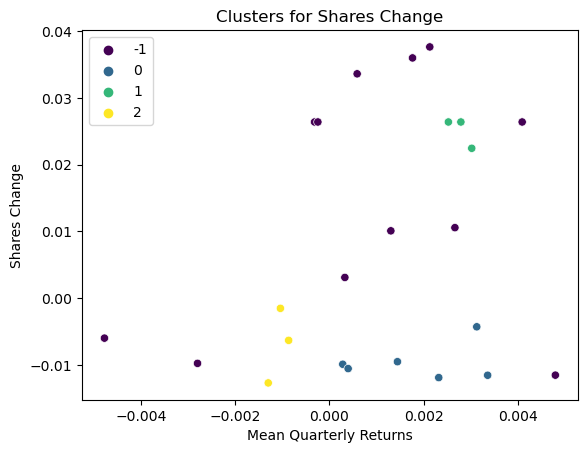

Metrics for Shares Change - Silhouette: 0.0451660883309549, Davies Bouldin: 1.2837910160616, Calinski Harabasz: 3.9945292875912366


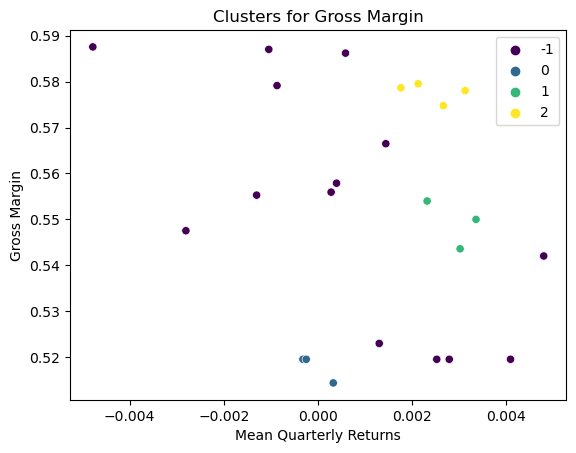

Metrics for Gross Margin - Silhouette: 0.11541374480849674, Davies Bouldin: 1.3004061716395185, Calinski Harabasz: 3.073624929470365


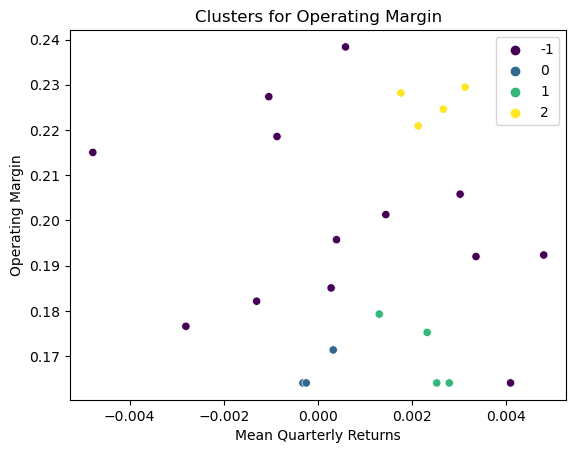

Metrics for Operating Margin - Silhouette: 0.11131426438651877, Davies Bouldin: 1.1537985596171179, Calinski Harabasz: 4.3229135203715945


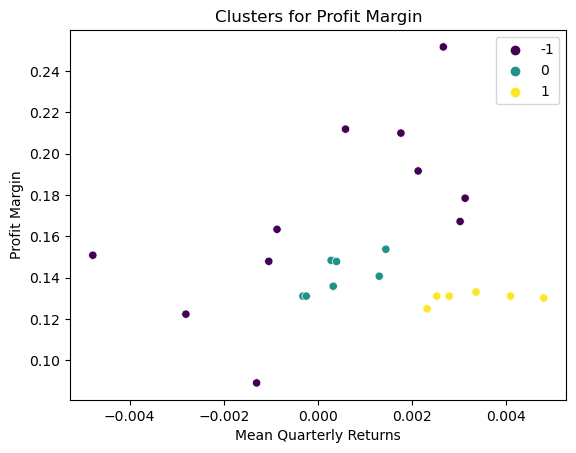

Metrics for Profit Margin - Silhouette: 0.2199631507663091, Davies Bouldin: 1.784558034694596, Calinski Harabasz: 4.74734596914454


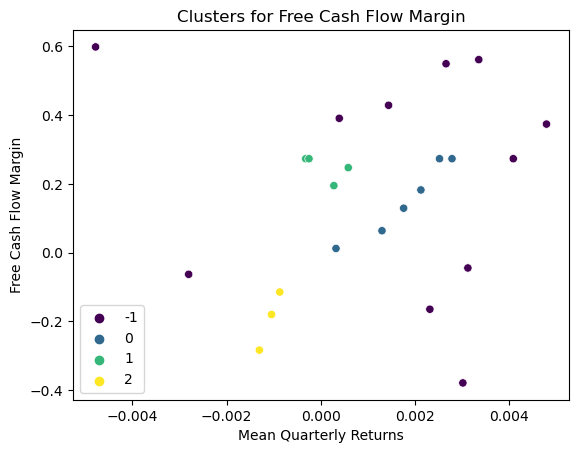

Metrics for Free Cash Flow Margin - Silhouette: 0.0926034619963873, Davies Bouldin: 4.395906097304475, Calinski Harabasz: 2.1255398062388213


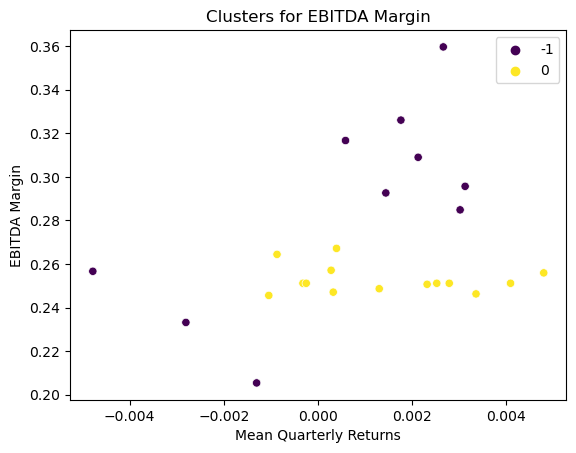

Metrics for EBITDA Margin - Silhouette: 0.2694961443899539, Davies Bouldin: 2.079934053216113, Calinski Harabasz: 3.9880969386137632


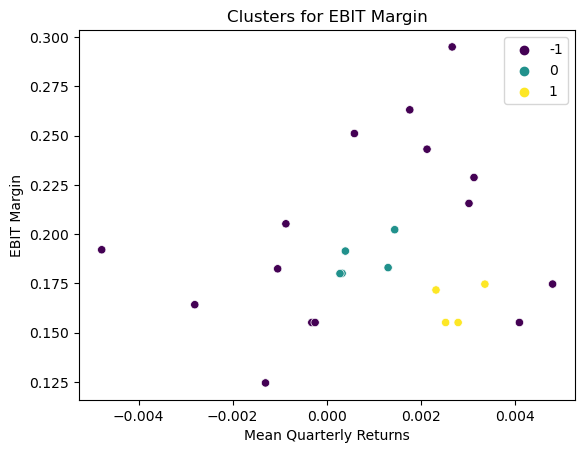

Metrics for EBIT Margin - Silhouette: 0.00978801456133549, Davies Bouldin: 4.2857211461044695, Calinski Harabasz: 1.3688207919540978


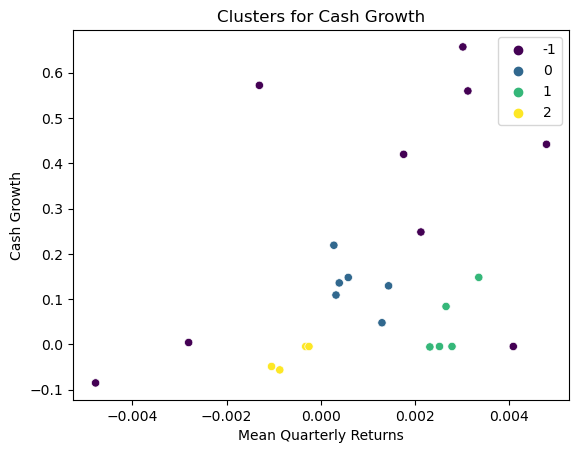

Metrics for Cash Growth - Silhouette: 0.2463683469181349, Davies Bouldin: 1.7674277450949452, Calinski Harabasz: 2.9343351916214533


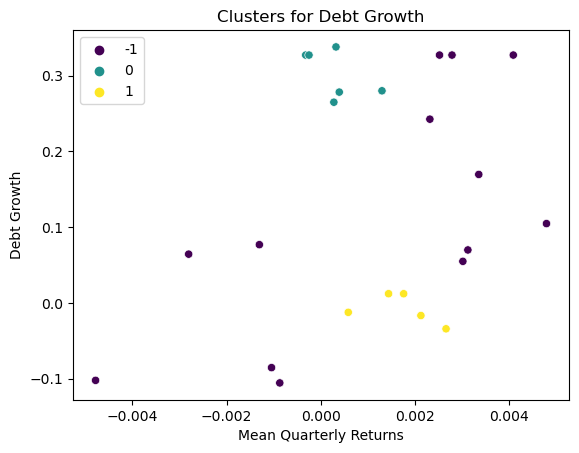

Metrics for Debt Growth - Silhouette: 0.16900062092447476, Davies Bouldin: 1.9647562499483453, Calinski Harabasz: 3.7377370292425467


In [23]:
dbscan.clustering_with_quarterly_returns()

# ARMIA visualizations

AAPL


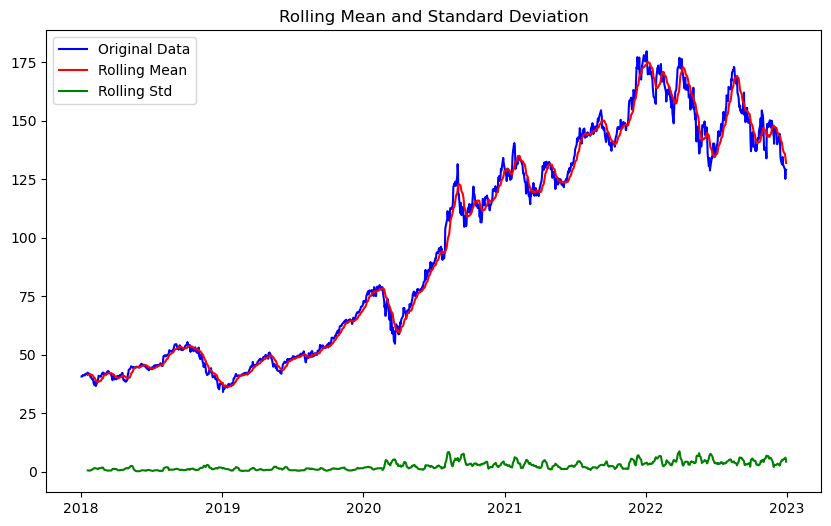

ADF Statistic: -1.0638032652304377
p-value: 0.7292888614630008
Critical Values:
1%: -3.4356048614183443
5%: -2.8638605461891617
10%: -2.5680054872544145
AMD


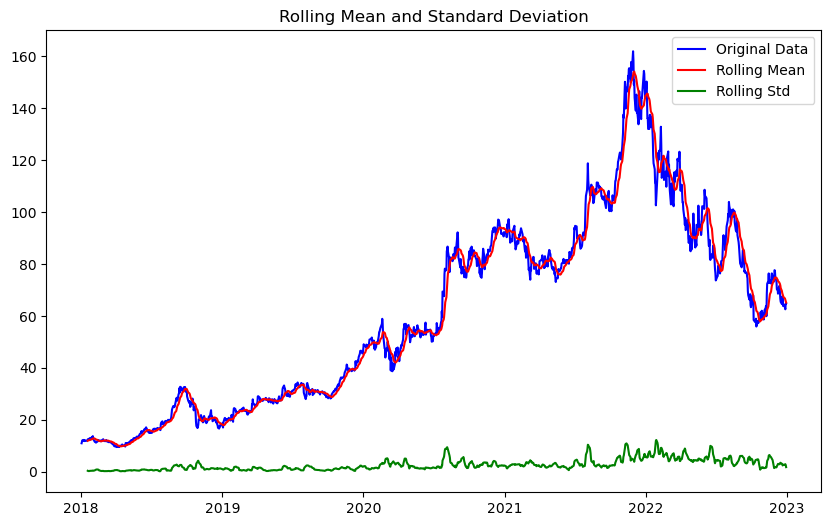

ADF Statistic: -1.512308971876385
p-value: 0.5274137169931019
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416
AMZN


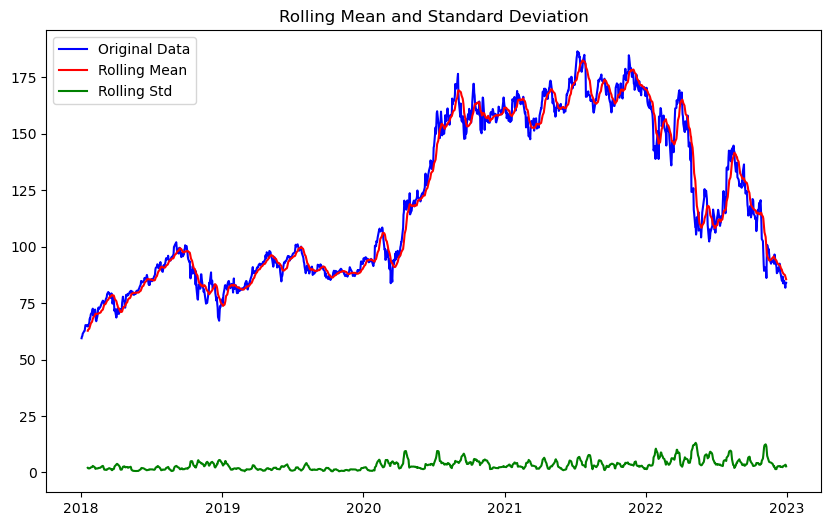

ADF Statistic: -1.7054380039010952
p-value: 0.4283128541618343
Critical Values:
1%: -3.4355588184378574
5%: -2.8638402312881497
10%: -2.5679946684494275
F


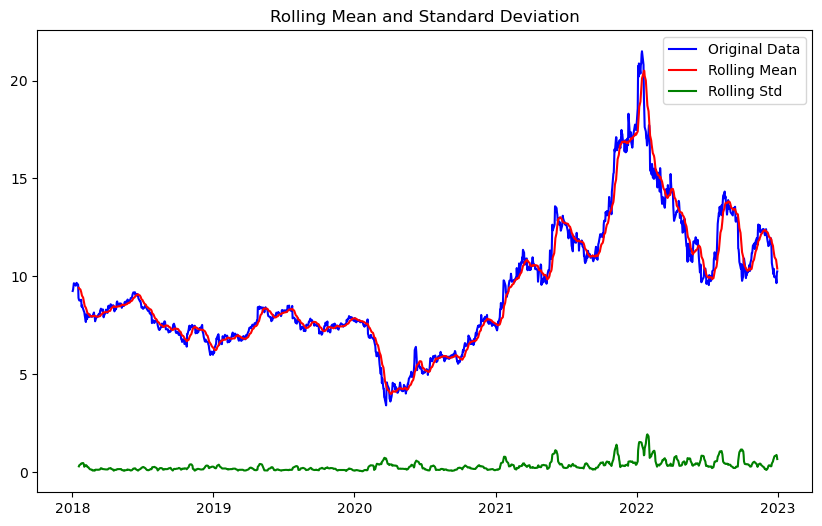

ADF Statistic: -1.438554935444559
p-value: 0.5636592810739032
Critical Values:
1%: -3.4355588184378574
5%: -2.8638402312881497
10%: -2.5679946684494275
GOOG


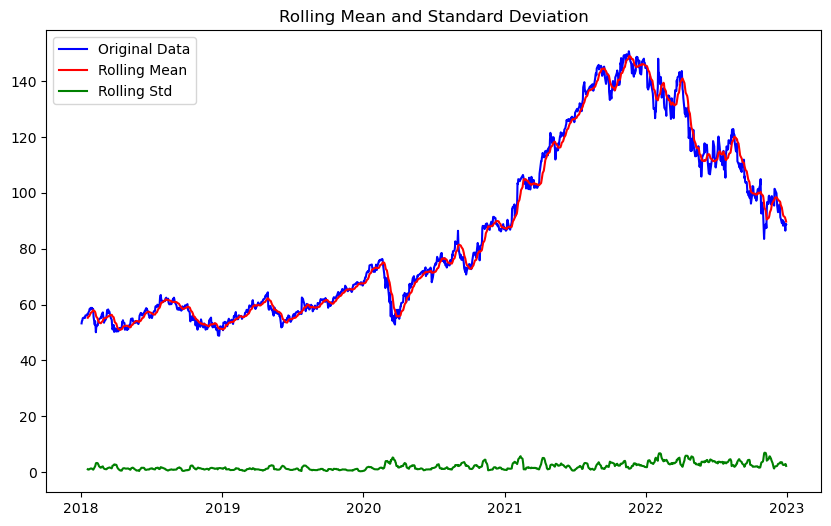

ADF Statistic: -1.210834526787703
p-value: 0.6689176927500178
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416
INTC


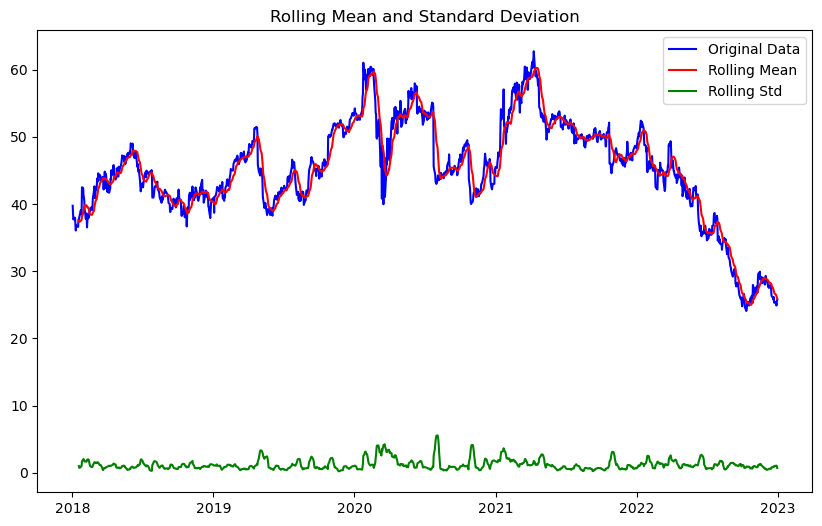

ADF Statistic: -1.693811834122274
p-value: 0.43430359340885405
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626
JPM


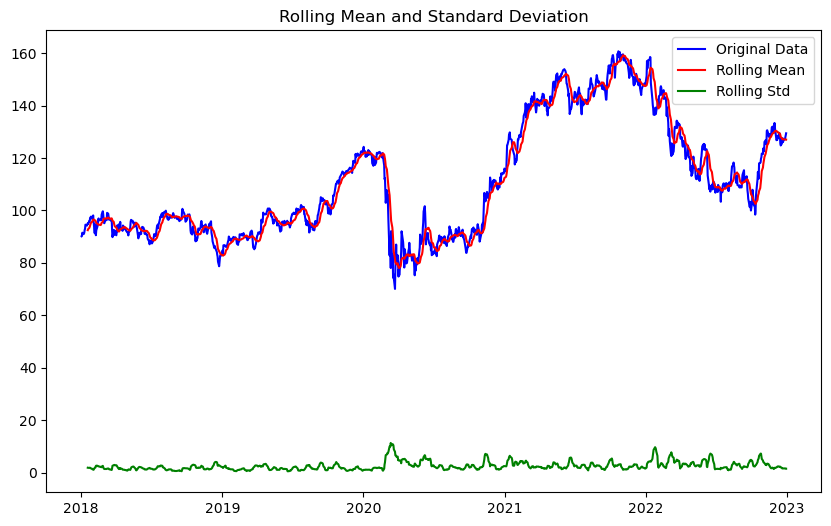

ADF Statistic: -1.4722532485304018
p-value: 0.5471899014440734
Critical Values:
1%: -3.4356133204636095
5%: -2.8638642784217305
10%: -2.5680074748794373
MSFT


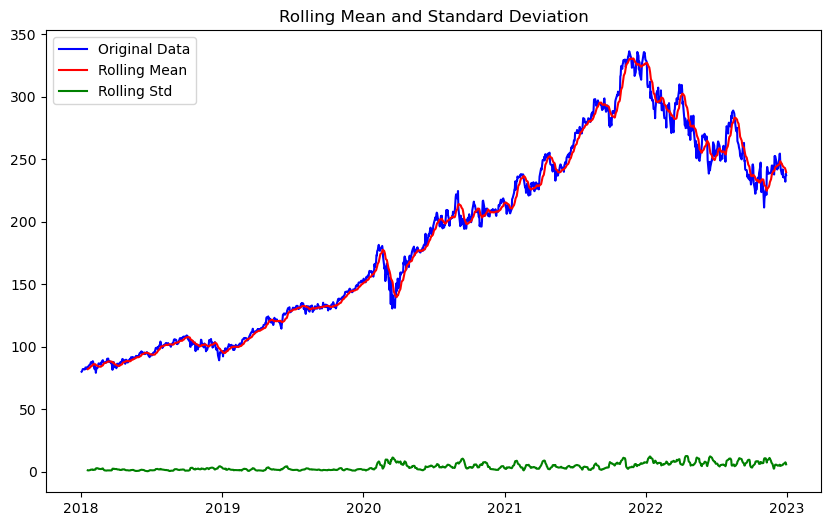

ADF Statistic: -1.2874764129153728
p-value: 0.634882216289284
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626
MS


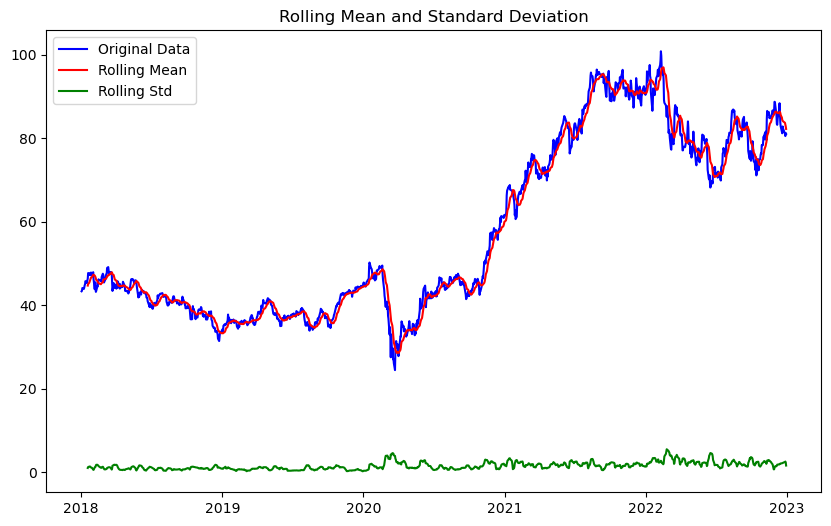

ADF Statistic: -0.743550177594831
p-value: 0.8351443626372537
Critical Values:
1%: -3.435592223709696
5%: -2.8638549702604803
10%: -2.56800251776
NVDA


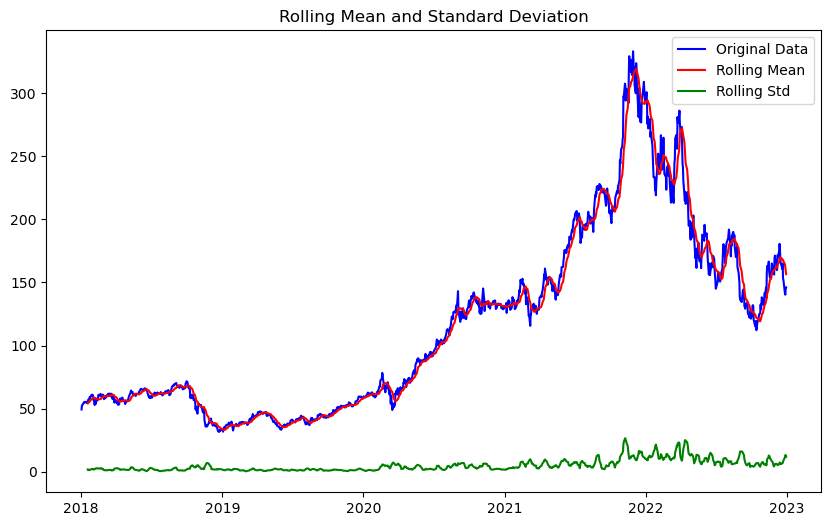

ADF Statistic: -1.188875318599872
p-value: 0.6783628678327054
Critical Values:
1%: -3.435630320520318
5%: -2.863871779019612
10%: -2.56801146937726
TSLA


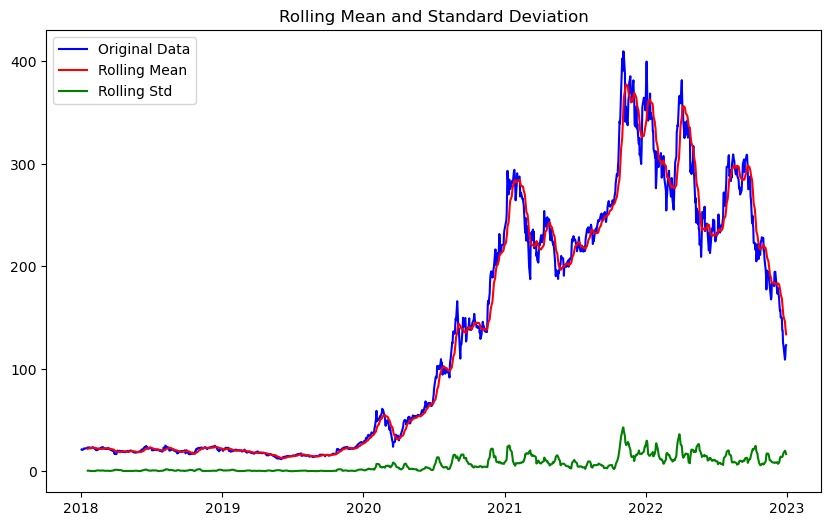

ADF Statistic: -1.301075667011038
p-value: 0.6286800511343598
Critical Values:
1%: -3.435634587707382
5%: -2.8638736617392837
10%: -2.568012472034339
VOO


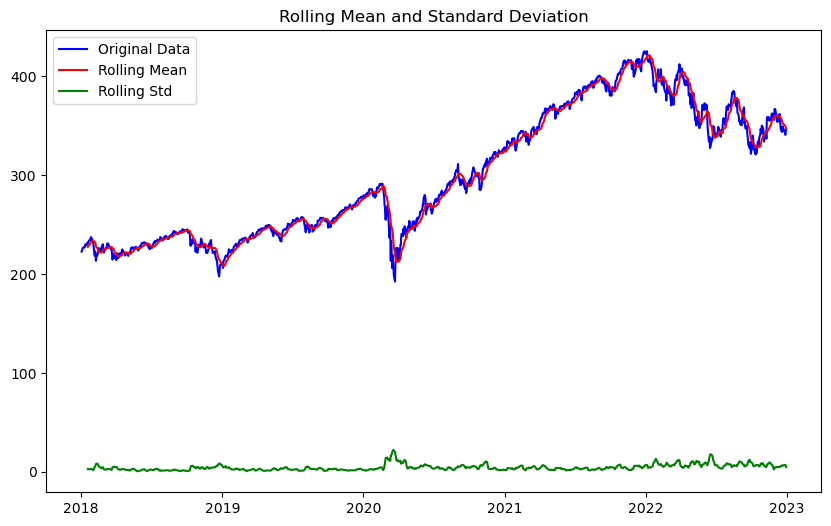

ADF Statistic: -1.1490807366527291
p-value: 0.6951077718585853
Critical Values:
1%: -3.4356006420838963
5%: -2.8638586845641063
10%: -2.5680044958343604


In [24]:
# Check for stationarity using the Augmented Dickey-Fuller test
models = []
for col in train_data.columns:
    print(col)
    adj_closed = train_data[col]
    # columns_except_first = stock_data.iloc[:, 1:]
    arima = MyARIMA(adj_closed)
    models.append((arima,col))
    arima.check_stationarity(adj_closed)

Looking at the Rolling Mean and Original Data, We are deciding whether the time series can be captured by a normal time series or 
it needs to be converted to logarithm

In [25]:
convert_log = {'AAPL' : True,'AMD' : True,'AMZN': False,'F': True,'GOOG' : False,'INTC':False,'JPM':False,'MSFT':False, 'MS': True,
               'NVDA':True, 'TSLA':True,'VOO':False}

The plot depicts increasing mean and standard deviation. Additionally p-value > 0.05. Hence, the timeseries is not stationary.

Additionally, the test statistics exceeds the critical values. As a result, the data is nonlinear.

### Make the time-series stationary

### ACF and PACF plots 

AAPL


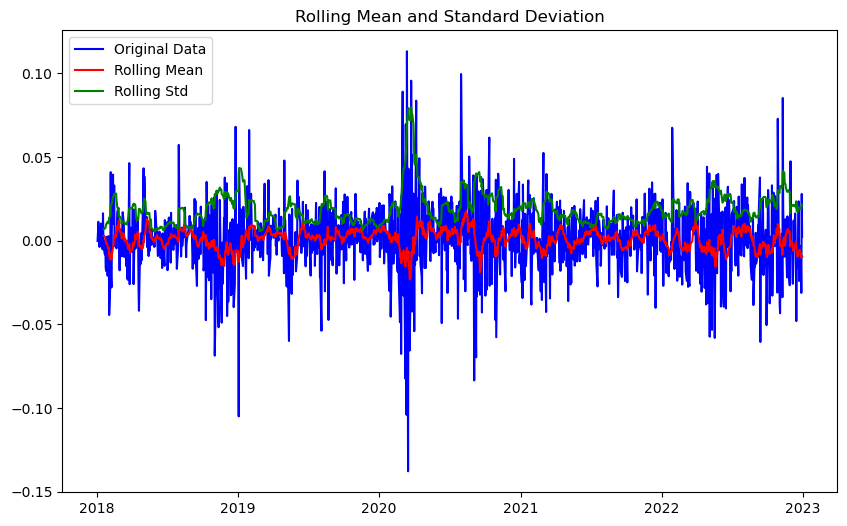

ADF Statistic: -11.071302356820915
p-value: 4.546352997700879e-20
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626


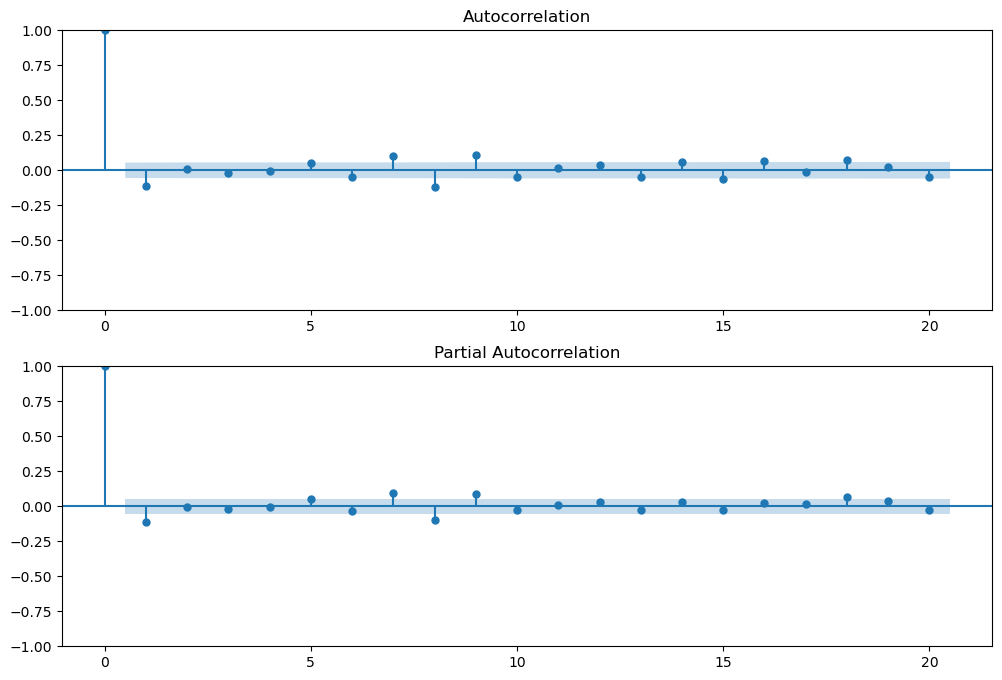

AMD


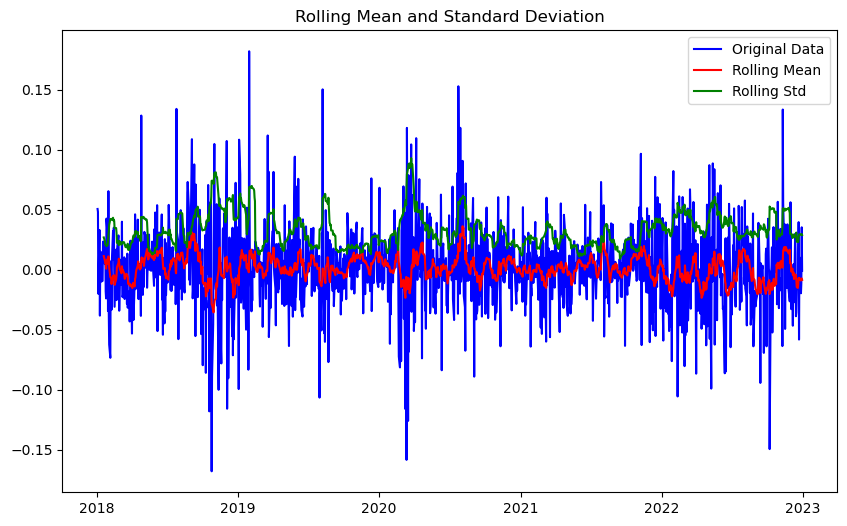

ADF Statistic: -21.30208965431885
p-value: 0.0
Critical Values:
1%: -3.435571295403709
5%: -2.863845736356174
10%: -2.567997600196822


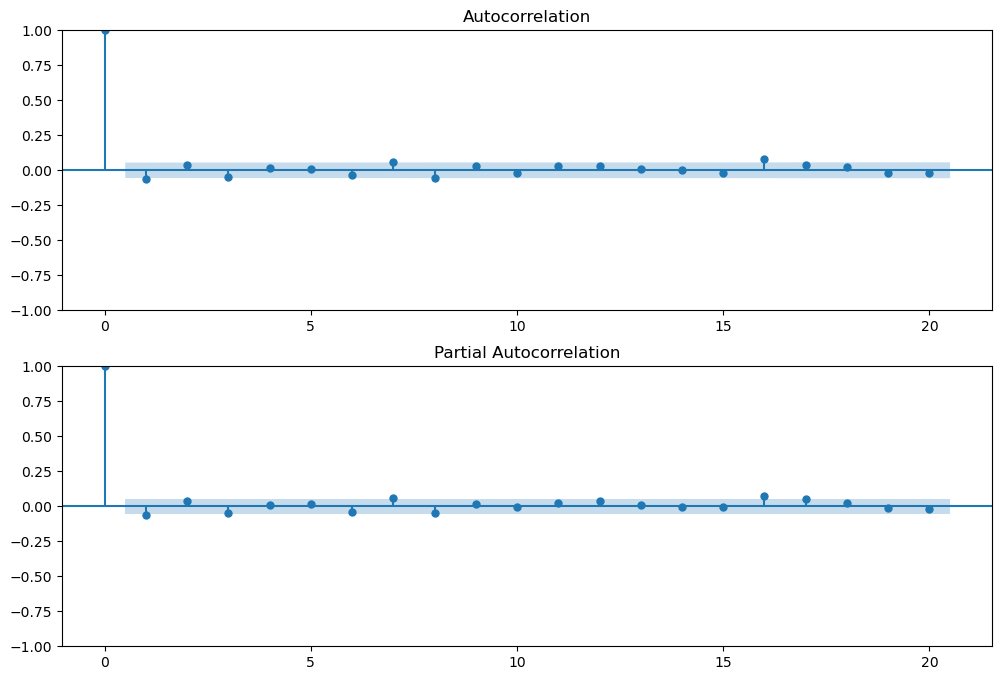

AMZN


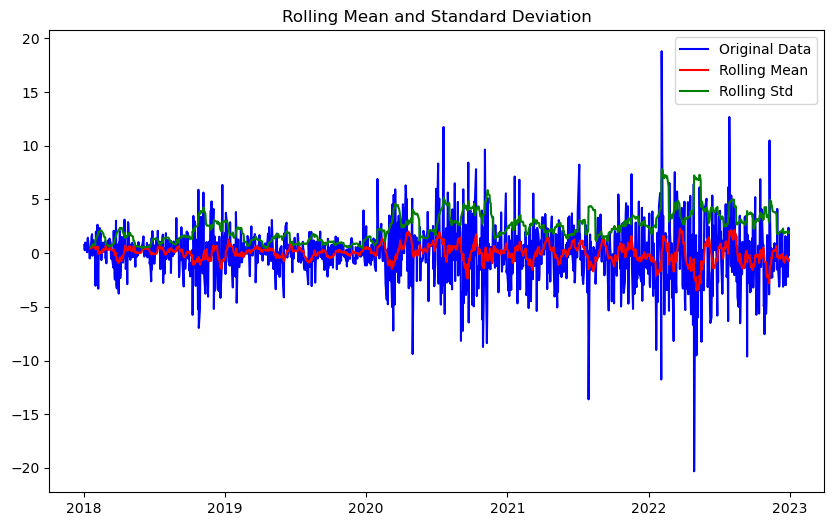

ADF Statistic: -36.13716788912933
p-value: 0.0
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416


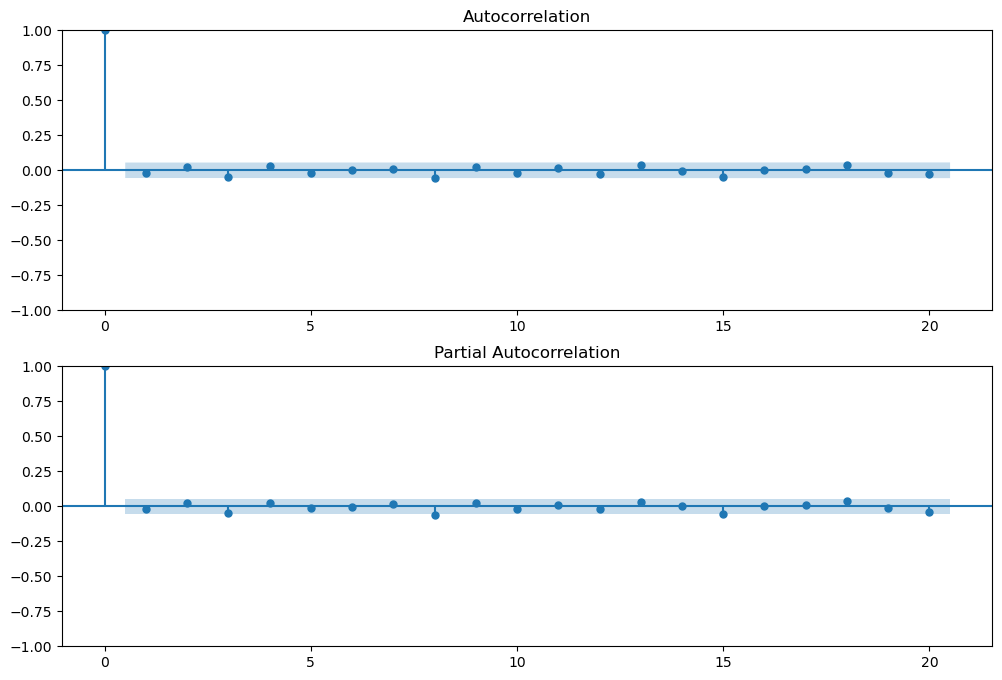

F


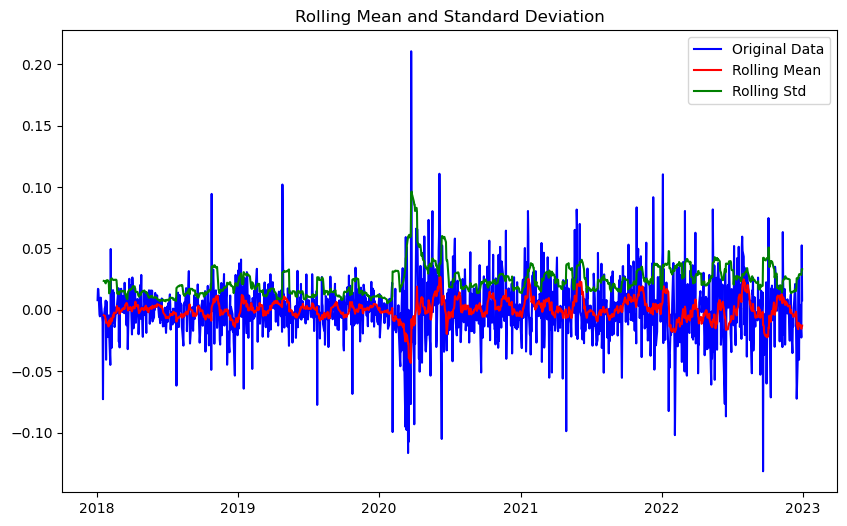

ADF Statistic: -10.888775095221412
p-value: 1.2404053268587279e-19
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626


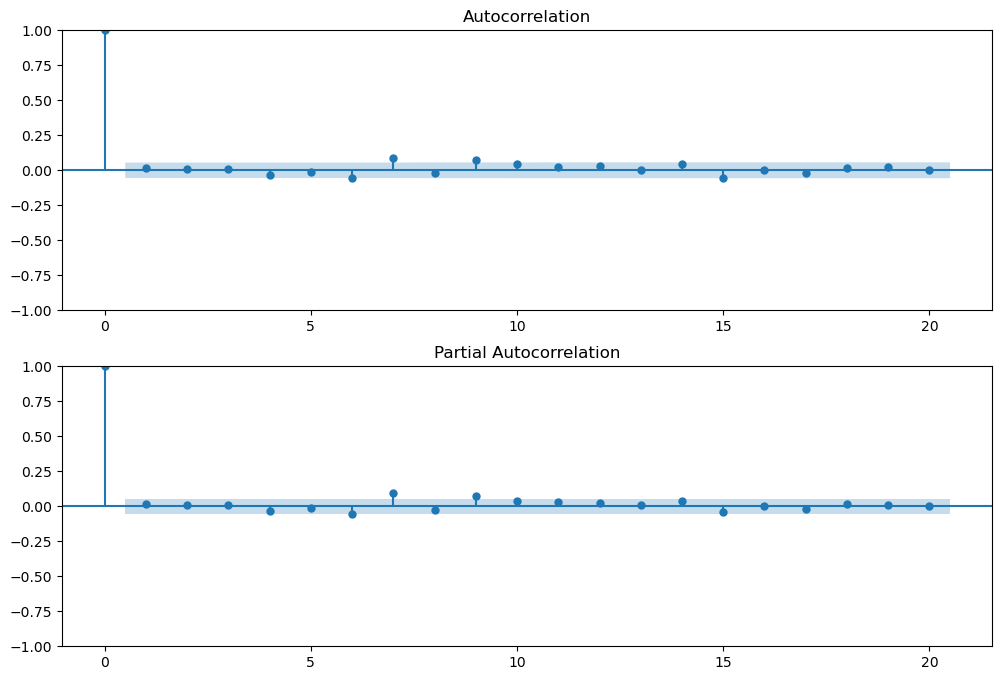

GOOG


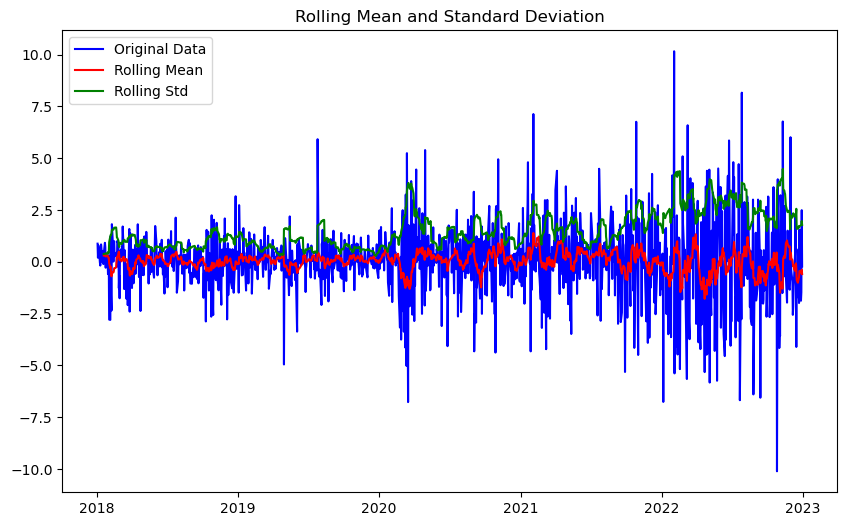

ADF Statistic: -37.739611097324584
p-value: 0.0
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416


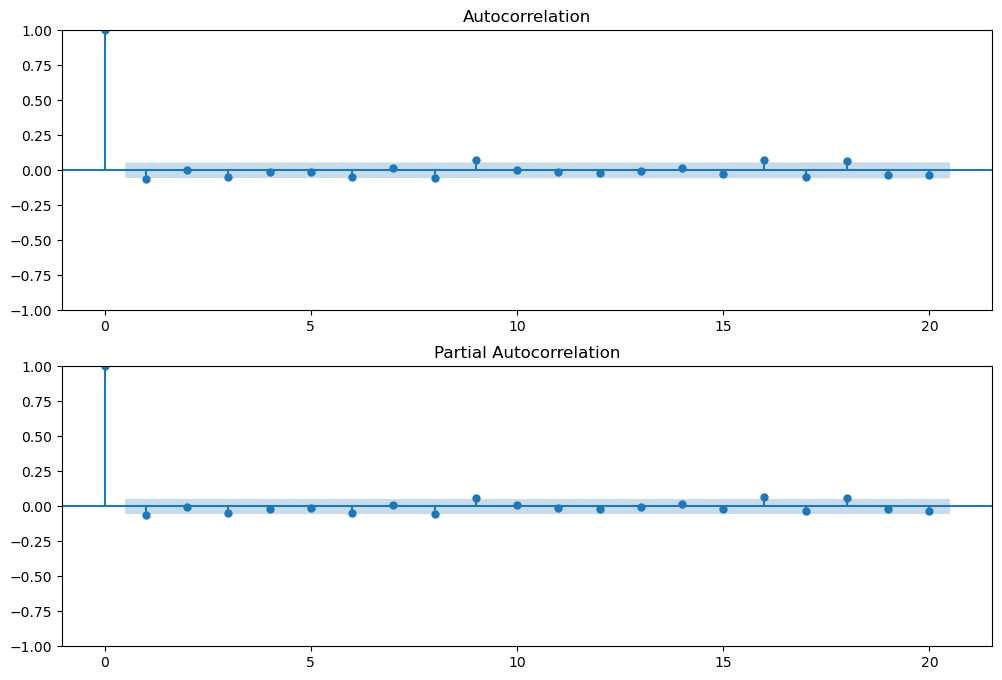

INTC


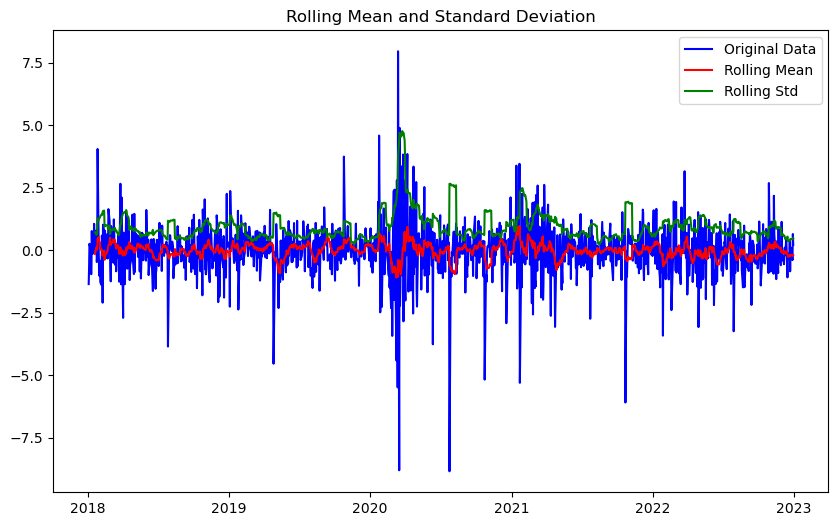

ADF Statistic: -11.73327448489709
p-value: 1.3260038850277394e-21
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626


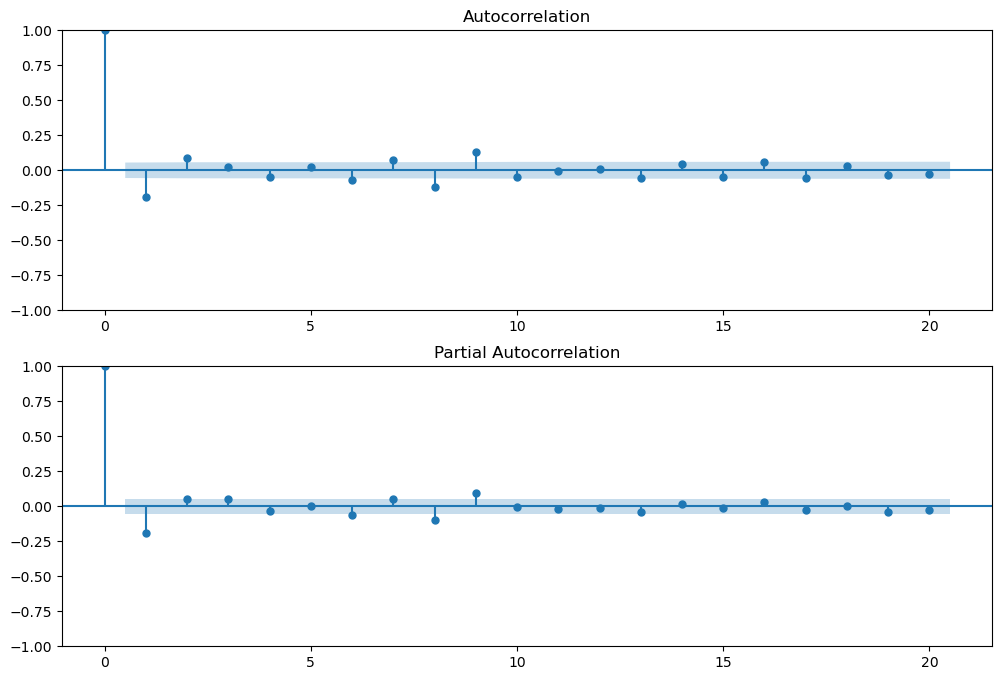

JPM


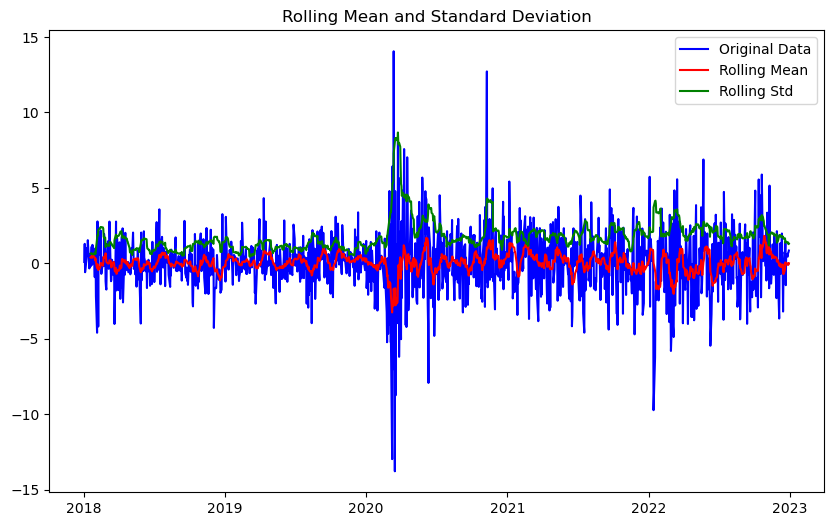

ADF Statistic: -10.612216706206885
p-value: 5.794739398928595e-19
Critical Values:
1%: -3.4356133204636095
5%: -2.8638642784217305
10%: -2.5680074748794373


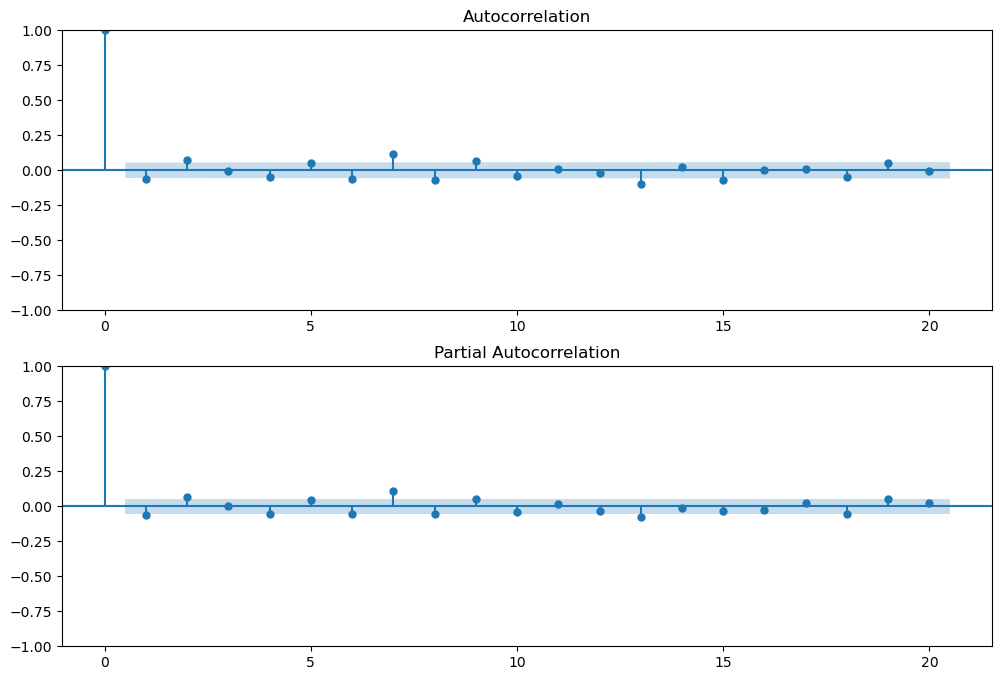

MSFT


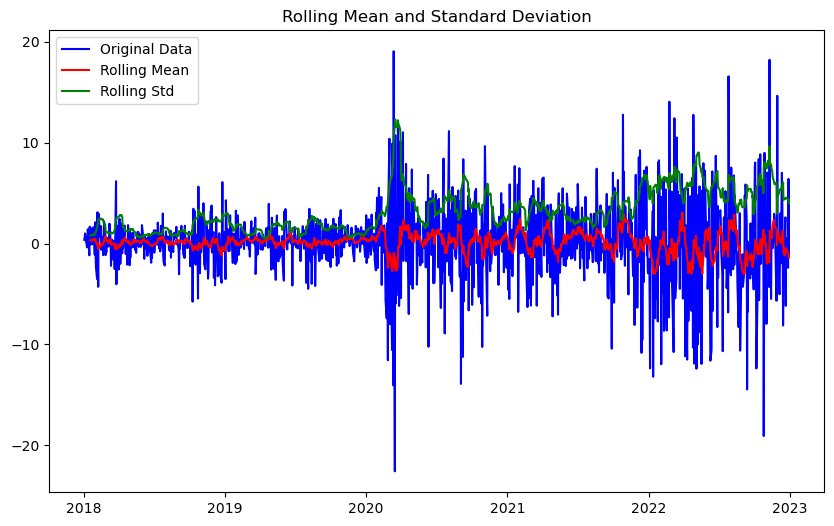

ADF Statistic: -11.98444714056111
p-value: 3.6406990866817486e-22
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626


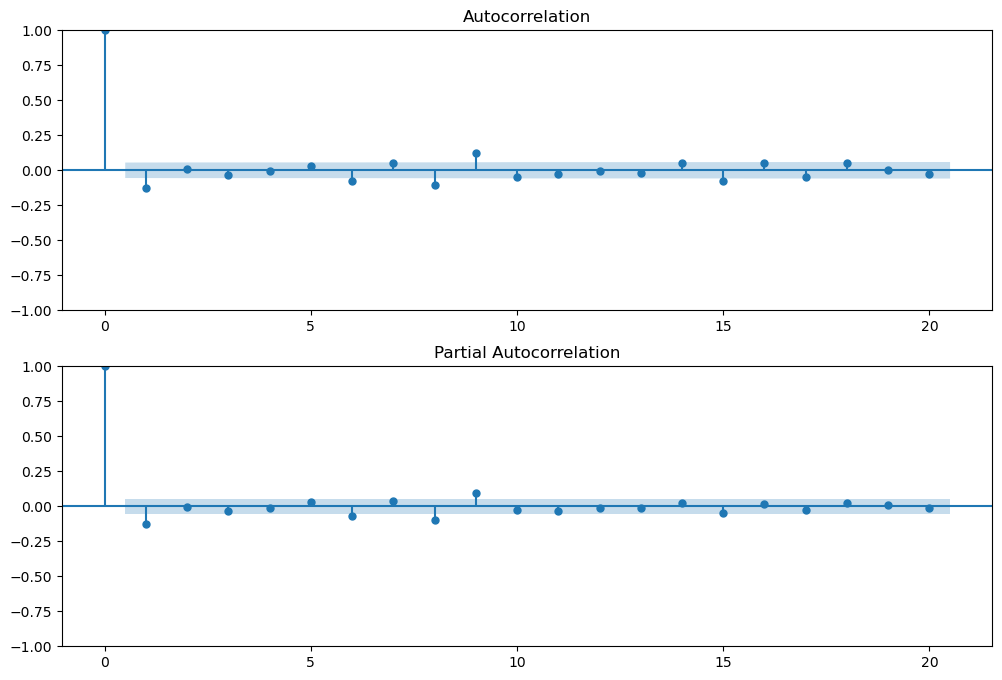

MS


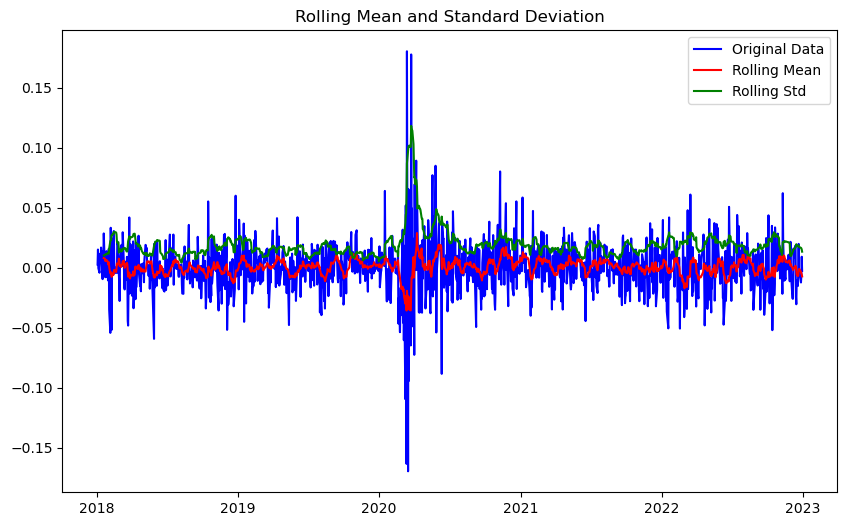

ADF Statistic: -10.83781459412424
p-value: 1.6448853243547561e-19
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626


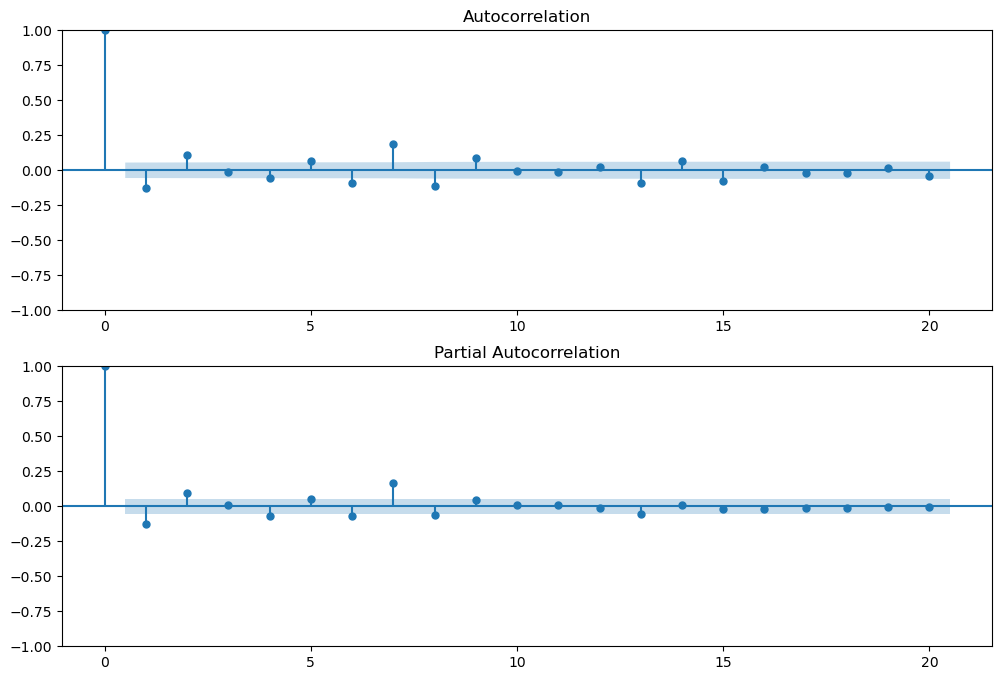

NVDA


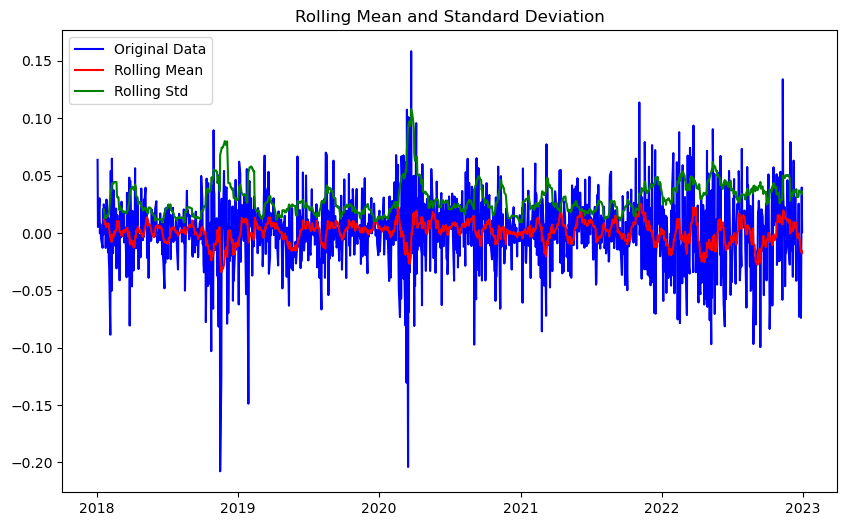

ADF Statistic: -11.585536043262222
p-value: 2.873648731176488e-21
Critical Values:
1%: -3.4355964295197743
5%: -2.863856825923603
10%: -2.5680035060041626


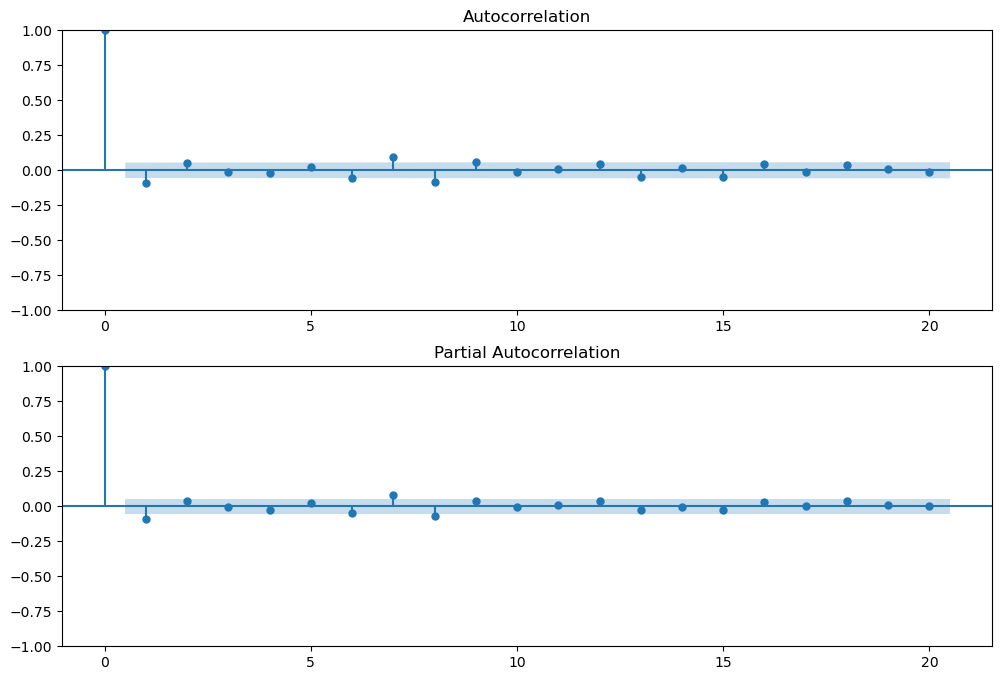

TSLA


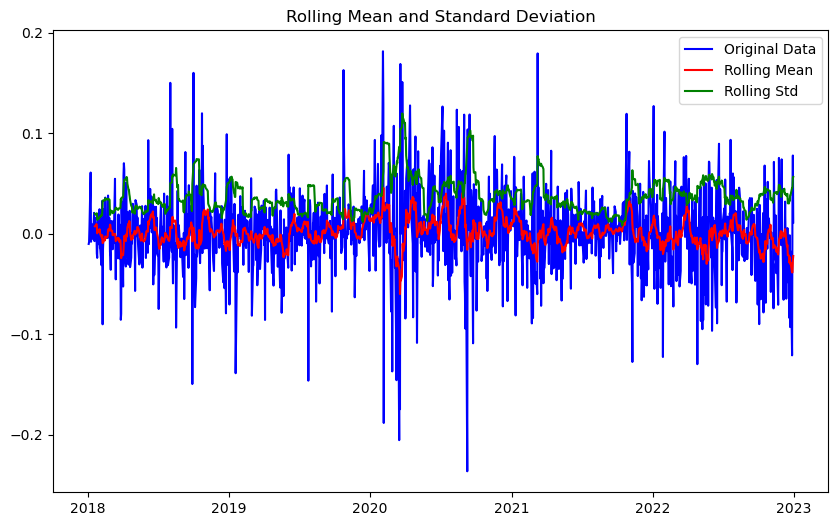

ADF Statistic: -24.148350343702177
p-value: 0.0
Critical Values:
1%: -3.4355671297788666
5%: -2.8638438984080117
10%: -2.5679966213893057


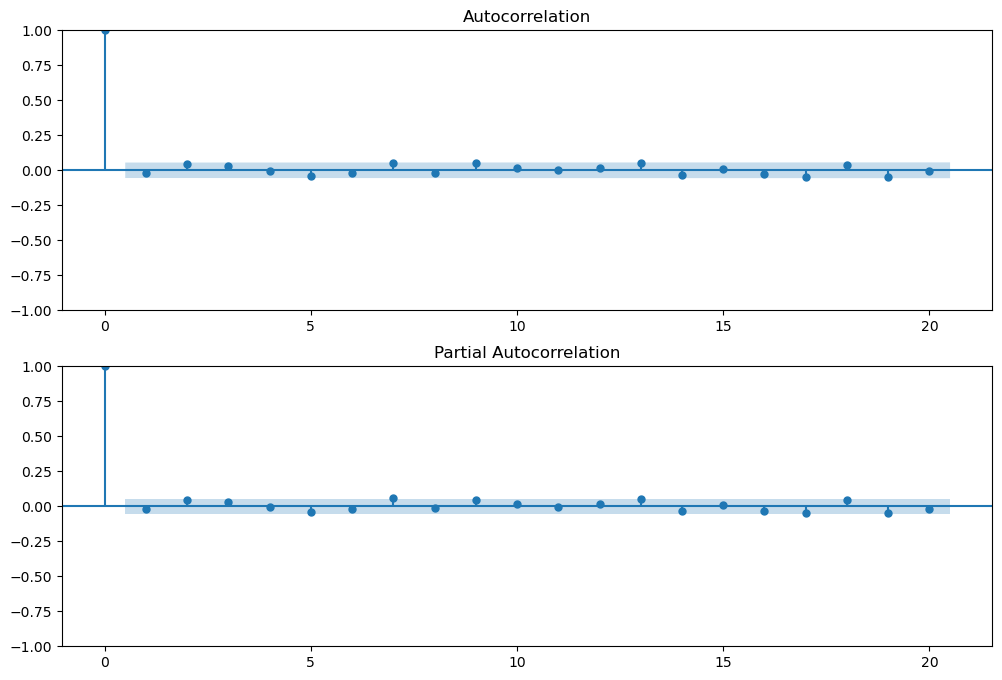

VOO


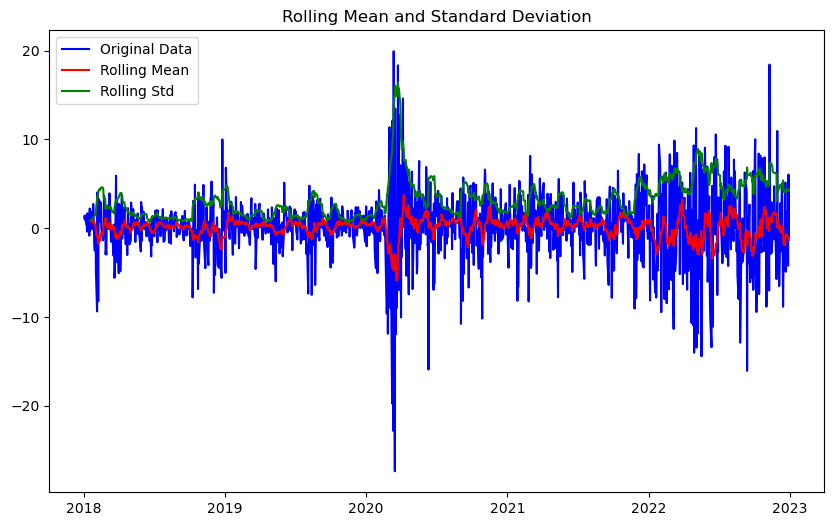

ADF Statistic: -11.03199791560427
p-value: 5.637734930279371e-20
Critical Values:
1%: -3.4356006420838963
5%: -2.8638586845641063
10%: -2.5680044958343604


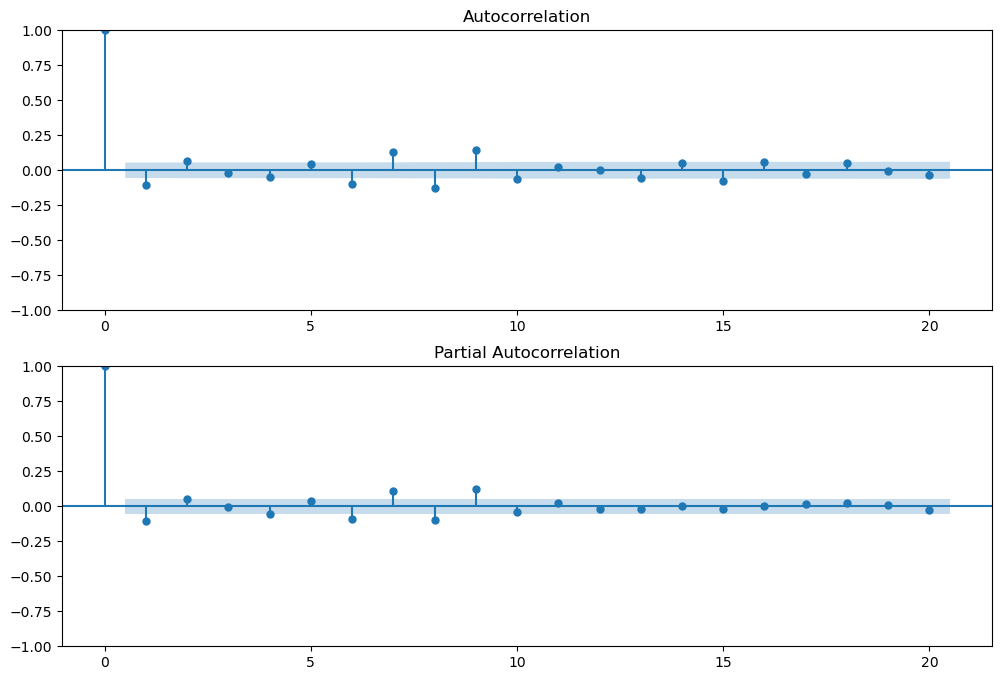

In [26]:
shift = 1
for arima,col in models:
    print(col)
    data = arima.time_series_data
    if convert_log[col]:
        data = arima.log_data(data)
    diff_data = arima.difference_data(data,shift)[1:]
    arima.check_stationarity(diff_data)
    arima.acf_pacf_plots(diff_data)

All p-values are well below the threshold, so we can consider the difference time series to be stationary. So the degree d of ARIMA(p,d,q) for all stocks is 1.

For p and q values, we will use the auto arima function to get the parameters for the ARIMA model

In [27]:
forecasted_data = test_data.copy()
N = len(forecasted_data)
for arima,col in models:
    print(col)
    data = arima.time_series_data
    if convert_log[col]:
        data = arima.log_data(data)
    arima.fit_arima_parameters(data)
    if convert_log[col]:
        forecasted_data[col] = np.exp(arima.forecast(data,N))
    else:
        forecasted_data[col] = arima.forecast(data,N)


AAPL


/Users/kaushikarcot/anaconda3/envs/ml_portfolio_opt/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AMD


/Users/kaushikarcot/anaconda3/envs/ml_portfolio_opt/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AMZN
F
GOOG
INTC
JPM
MSFT
MS
NVDA
TSLA
VOO


In [28]:
mpt = MPTOptimizer()
l = list(test_data.columns)

In [30]:
arima_allocs = mpt.optimize_portfolio(forecasted_data)
print("Forecasted Data Allocation")
for val, ticker in zip(arima_allocs, l):
    print(ticker + ": " + str(round(val,3)))

Forecasted Data Allocation
AAPL: 0.0
AMD: 0.0
AMZN: 0.0
F: 0.0
GOOG: 0.946
INTC: 0.0
JPM: 0.0
MSFT: 0.0
MS: 0.013
NVDA: 0.041
TSLA: 0.0
VOO: 0.0


In [31]:
mpt_allocs = mpt.optimize_portfolio(train_data)
print("MyOptimizer's Data Allocation")
for val, ticker in zip(mpt_allocs, l):
    print(ticker + ": " + str(round(val,3)))

MyOptimizer's Data Allocation
AAPL: 0.0
AMD: 0.575
AMZN: 0.0
F: 0.0
GOOG: 0.0
INTC: 0.0
JPM: 0.0
MSFT: 0.0
MS: 0.0
NVDA: 0.0
TSLA: 0.425
VOO: 0.0


In [32]:
mean_arima, std_arima, cr_arima, sr_arima = utils.sharpe_ratio_metrics(test_data,arima_allocs)
treynor_arima,beta_arima,alpha_arima = utils.treynor_ratio_metrics(test_data,arima_allocs,index_data)
print("ARIMA Metrics")
print("Mean: " + str(mean_arima))
print("Std Dev: " + str(std_arima))
print("Calculated Risk: " + str(cr_arima))
print("Sharpe Ratio: " + str(sr_arima))
print("Treynor Ratio: " + str(treynor_arima))
print("Beta: " + str(beta_arima))
print("Alpha: " + str(alpha_arima))

ARIMA Metrics
Mean: 0.0022795553922053
Std Dev: 0.018683355787078724
Calculated Risk: 0.6882696373803454
Sharpe Ratio: 1.93684798479595
Treynor Ratio: 0.0014108051312231586
Beta: 1.4775643680839206
Alpha: 0.0008241597739148897


In [33]:
mean_mpt, std_mpt,cr_mpt, sr_mpt = utils.sharpe_ratio_metrics(test_data,mpt_allocs)
treynor_mpt,beta_mpt,alpha_mpt = utils.treynor_ratio_metrics(test_data,mpt_allocs,index_data)
print("MyOptimizer Metrics")
print("Mean: " + str(mean_mpt))
print("Std Dev: " + str(std_mpt))
print("Calculated Risk: " + str(cr_mpt))
print("Sharpe Ratio: " + str(sr_mpt))
print("Treynor Ratio: " + str(treynor_mpt))
print("Beta: " + str(beta_mpt))
print("Alpha: " + str(alpha_mpt))



MyOptimizer Metrics
Mean: 0.003703578123647948
Std Dev: 0.02666531118717098
Calculated Risk: 1.3003698374769281
Sharpe Ratio: 2.204830074734548
Treynor Ratio: 0.0016682319022800077
Beta: 2.1031716986425564
Alpha: 0.0016319615221416749


In [34]:
kmeans_allocs = [0,0,0,0,0,0,1.0/3,0,0,1.0/3,0,1.0/3]

In [35]:
mean_kmeans, std_kmeans,cr_kmeans, sr_kmeans = utils.sharpe_ratio_metrics(test_data,kmeans_allocs)
treynor_kmeans,beta_kmeans,alpha_kmeans = utils.treynor_ratio_metrics(test_data,kmeans_allocs,index_data)

print("KMeans Metrics")
print("Mean: " + str(mean_kmeans))
print("Std Dev: " + str(std_kmeans))
print("Calculated Risk: " + str(cr_kmeans))
print("Sharpe Ratio: " + str(sr_kmeans))
print("Treynor Ratio: " + str(treynor_kmeans))
print("Beta: " + str(beta_kmeans))
print("Alpha: " + str(alpha_kmeans))


KMeans Metrics
Mean: 0.0024301205188770837
Std Dev: 0.014783100219931046
Calculated Risk: 0.781850563290013
Sharpe Ratio: 2.6095316083410807
Treynor Ratio: 0.0016551490943836436
Beta: 1.3504043390782348
Alpha: 0.0010999770743898019


In [36]:
kmeans_pca_allocs = [0,0,0,0,0,0,1.0/4,0,0,1.0/4,1.0/4,1.0/4]

In [37]:
mean_kmeans_pca, std_kmeans_pca,cr_kmeans_pca, sr_kmeans_pca = utils.sharpe_ratio_metrics(test_data,kmeans_pca_allocs)
treynor_kmeans_pca,beta_kmeans_pca,alpha_kmeans_pca = utils.treynor_ratio_metrics(test_data,kmeans_pca_allocs,index_data)


print("KMeans w PCA Metrics")
print("Mean: " + str(mean_kmeans_pca))
print("Std Dev: " + str(std_kmeans_pca))
print("Calculated Risk: " + str(cr_kmeans_pca))
print("Sharpe Ratio: " + str(sr_kmeans_pca))
print("Treynor Ratio: " + str(treynor_kmeans_pca))
print("Beta: " + str(beta_kmeans_pca))
print("Alpha: " + str(alpha_kmeans_pca))

KMeans w PCA Metrics
Mean: 0.0026206417196446407
Std Dev: 0.016077347286175023
Calculated Risk: 0.8587911153777297
Sharpe Ratio: 2.5875784638461745
Treynor Ratio: 0.0016014204665979542
Beta: 1.51468135335978
Alpha: 0.0011286860036004605


In [38]:
seq_len = 100
num_epochs = 10000

In [39]:
val_data = train_data.tail(seq_len)

In [40]:
val_data.shape

(100, 12)

In [41]:
models, all_loss_tracks, scalars = MyLSTM.fit_all_tickers(train_data, seq_len, num_epochs)

--------------------------------------------------
Fitting model for ticker: AAPL
--------------------------------------------------
Epoch 0/10000, Loss=0.07974106073379517
Epoch 100/10000, Loss=0.05614941939711571
Epoch 200/10000, Loss=0.045411281287670135
Epoch 300/10000, Loss=0.033076364547014236
Epoch 400/10000, Loss=0.01880461350083351
Epoch 500/10000, Loss=0.005448262672871351
Epoch 600/10000, Loss=0.0011276983423158526
Epoch 700/10000, Loss=0.0010223265271633863
Epoch 800/10000, Loss=0.000993245979771018
Epoch 900/10000, Loss=0.0009647763217799366
Epoch 1000/10000, Loss=0.0009364126599393785
Epoch 1100/10000, Loss=0.0009081714670173824
Epoch 1200/10000, Loss=0.00088018603855744
Epoch 1300/10000, Loss=0.0008525951416231692
Epoch 1400/10000, Loss=0.0008255167049355805
Epoch 1500/10000, Loss=0.0007990463054738939
Epoch 1600/10000, Loss=0.0007732558296993375
Epoch 1700/10000, Loss=0.0007482002838514745
Epoch 1800/10000, Loss=0.0007239187834784389
Epoch 1900/10000, Loss=0.00070043816

(100, 0)
Evaluating model for ticker: AAPL
100


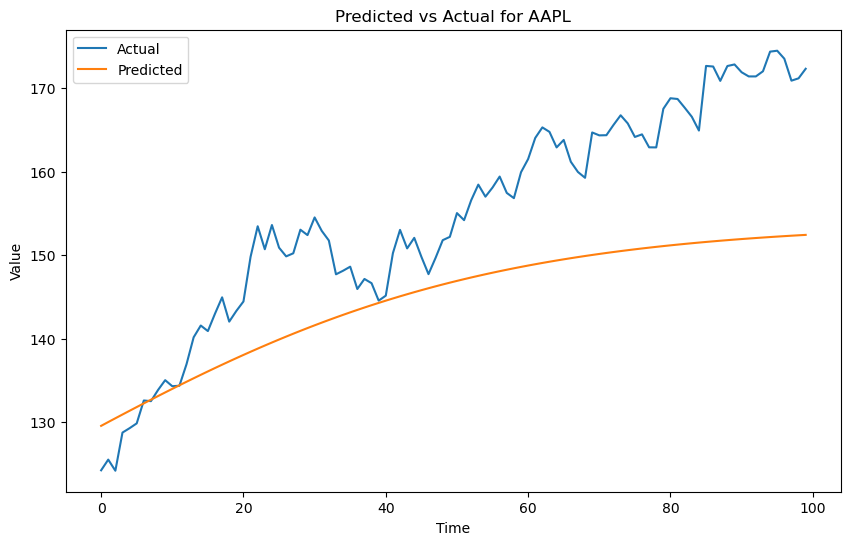

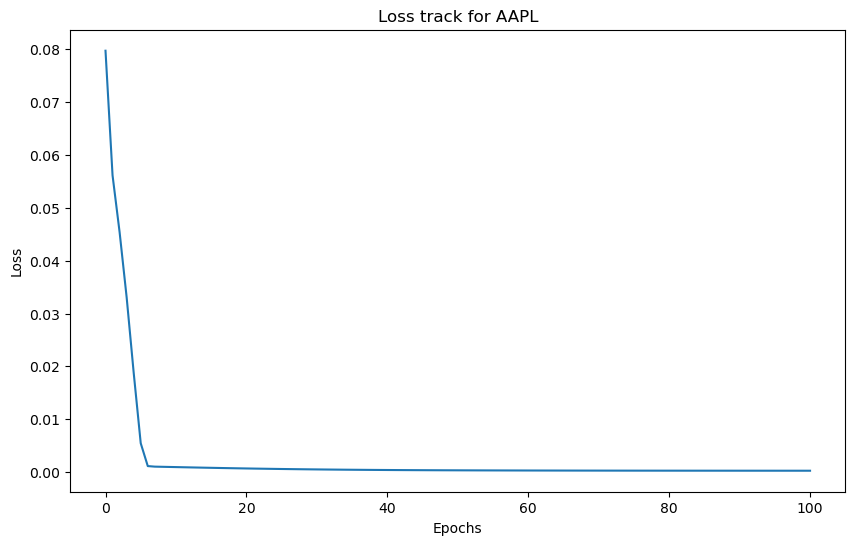

Evaluating model for ticker: AMD
100


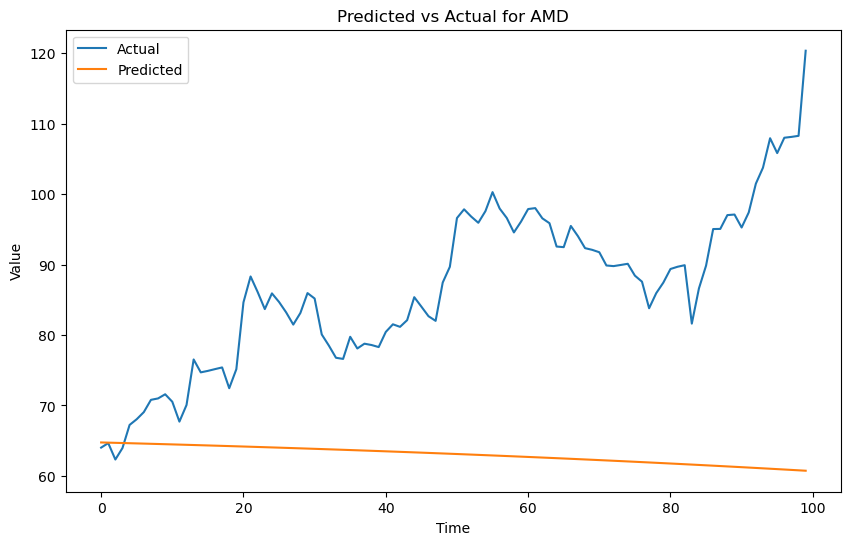

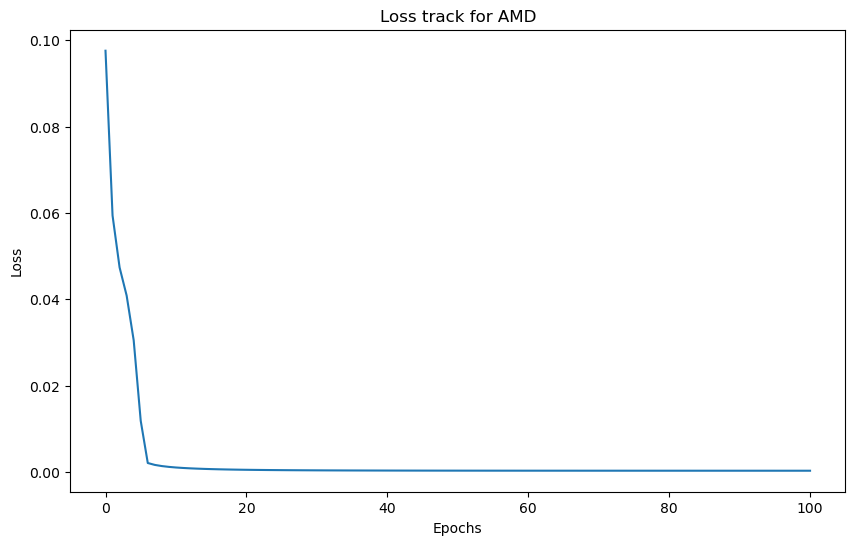

Evaluating model for ticker: AMZN
100


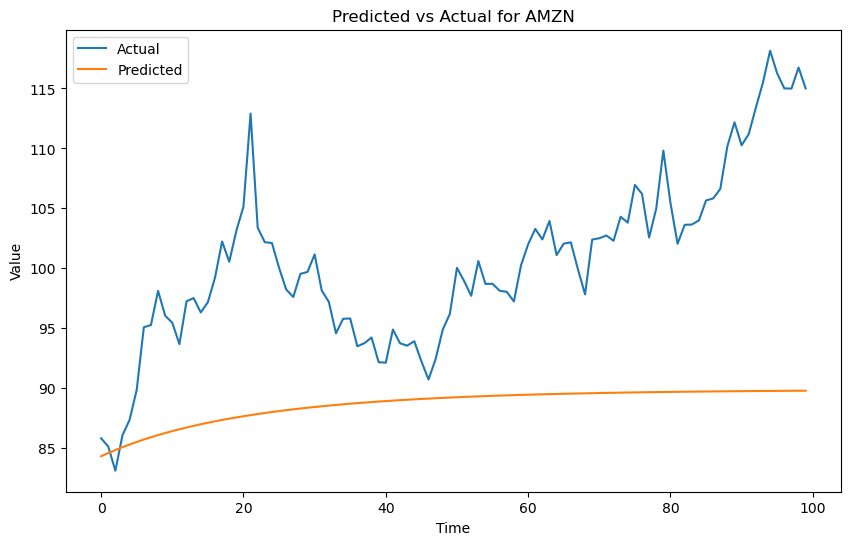

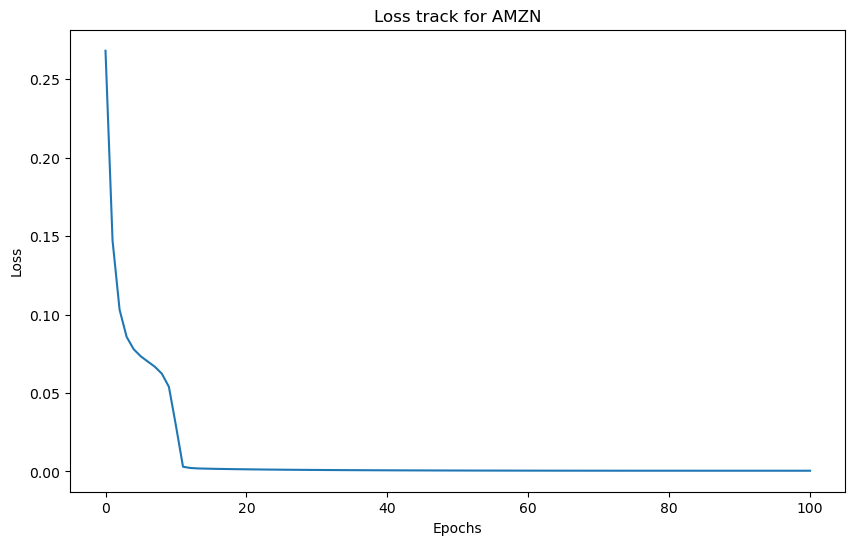

Evaluating model for ticker: F
100


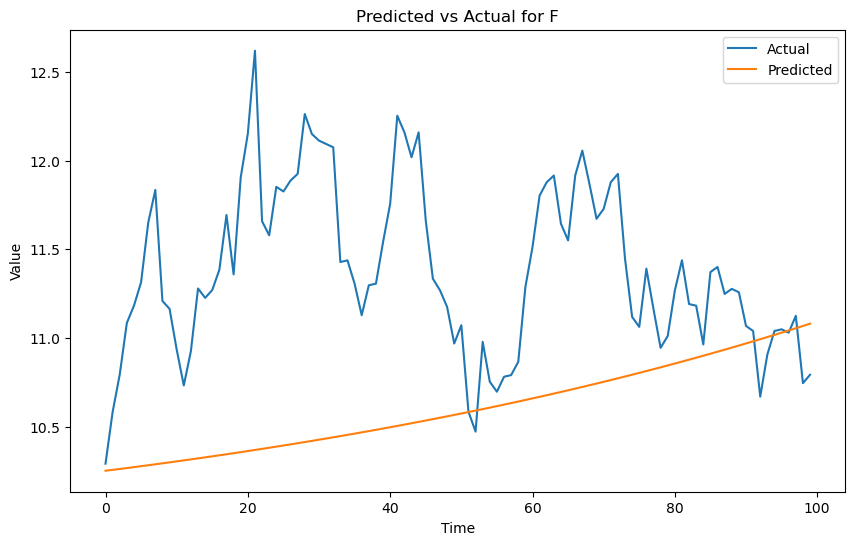

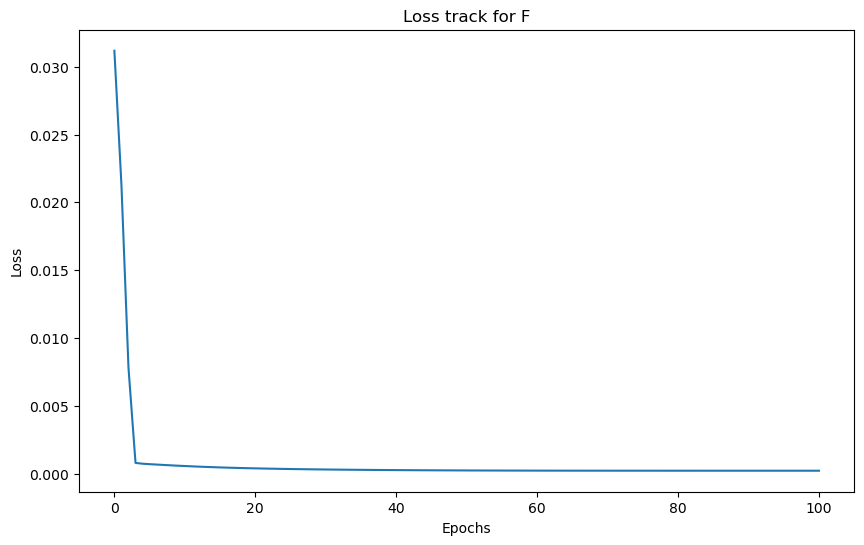

Evaluating model for ticker: GOOG
100


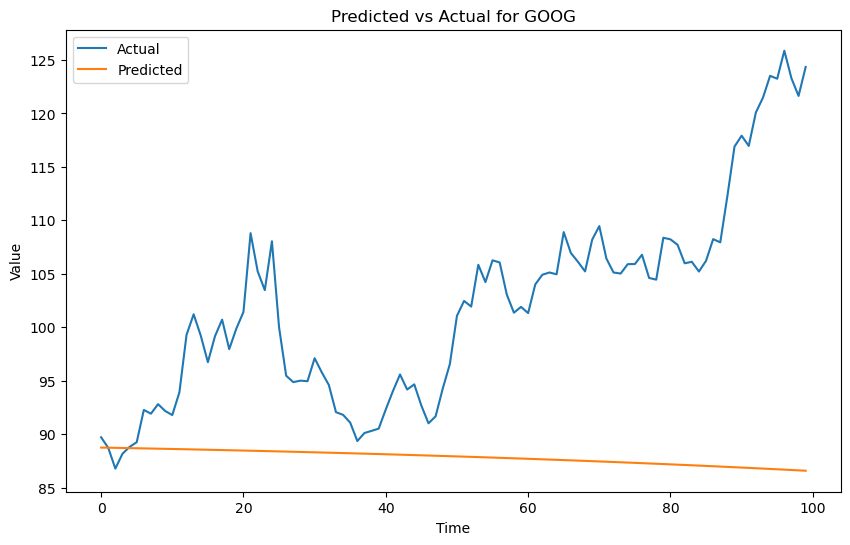

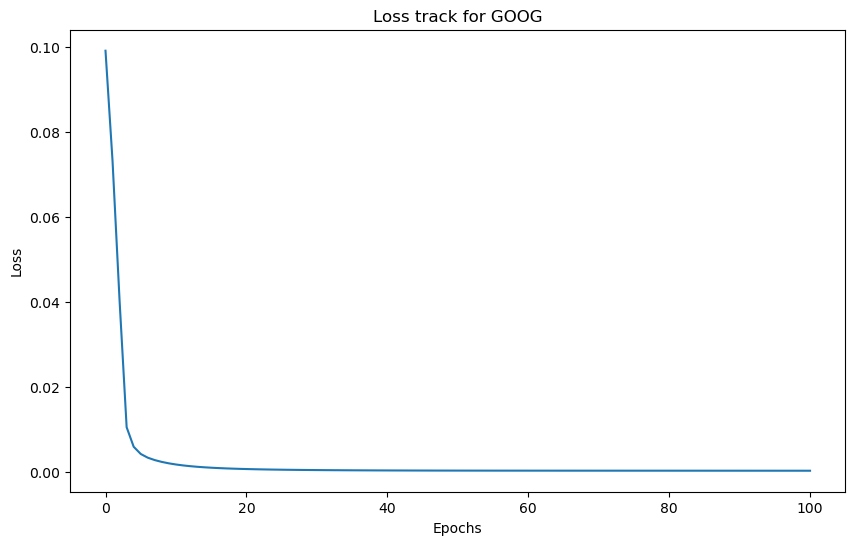

Evaluating model for ticker: INTC
100


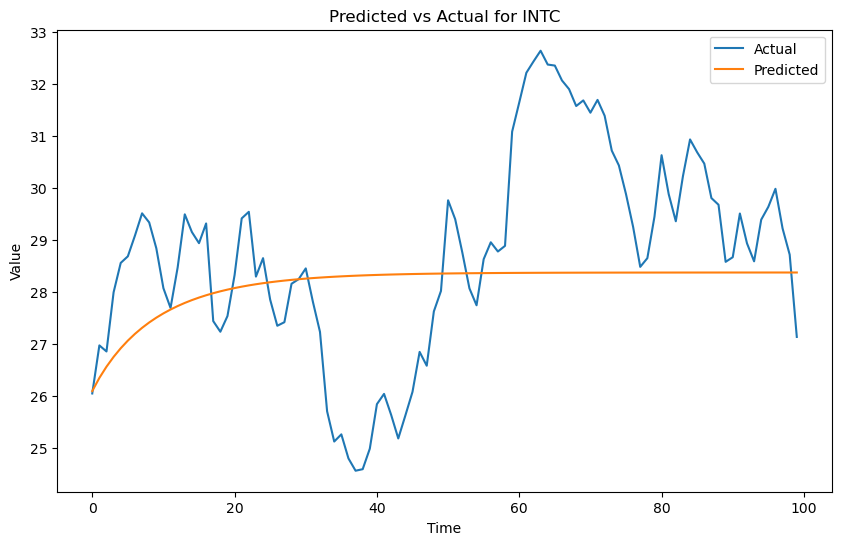

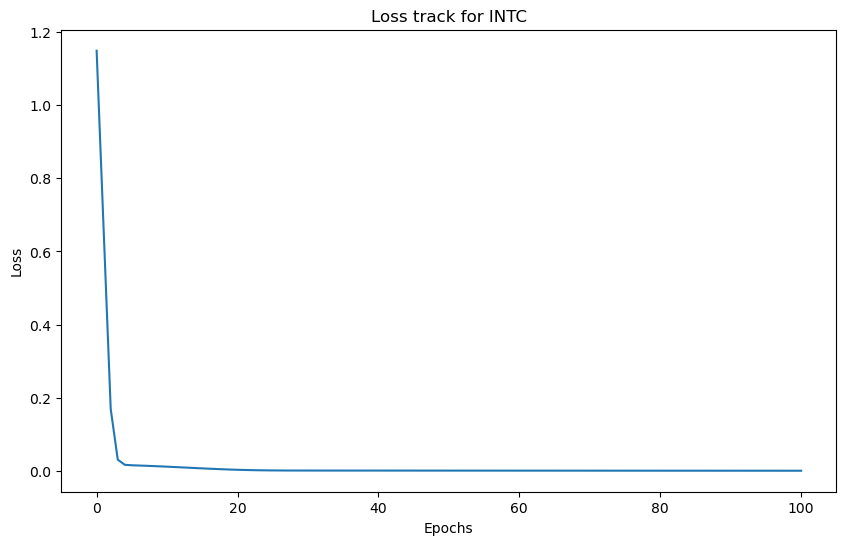

Evaluating model for ticker: JPM
100


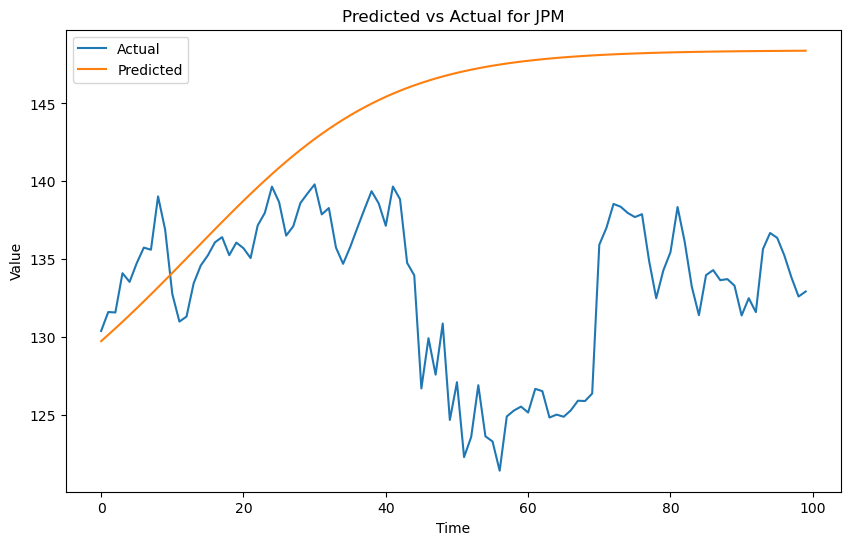

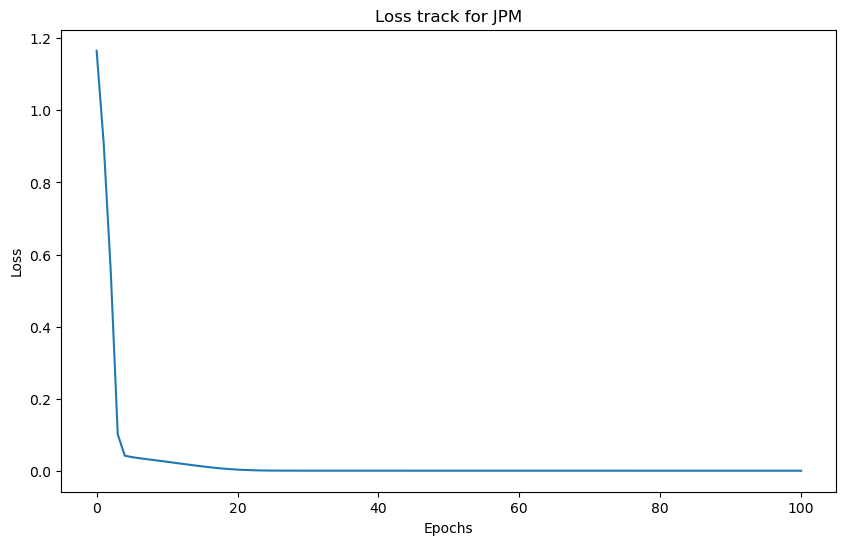

Evaluating model for ticker: MSFT
100


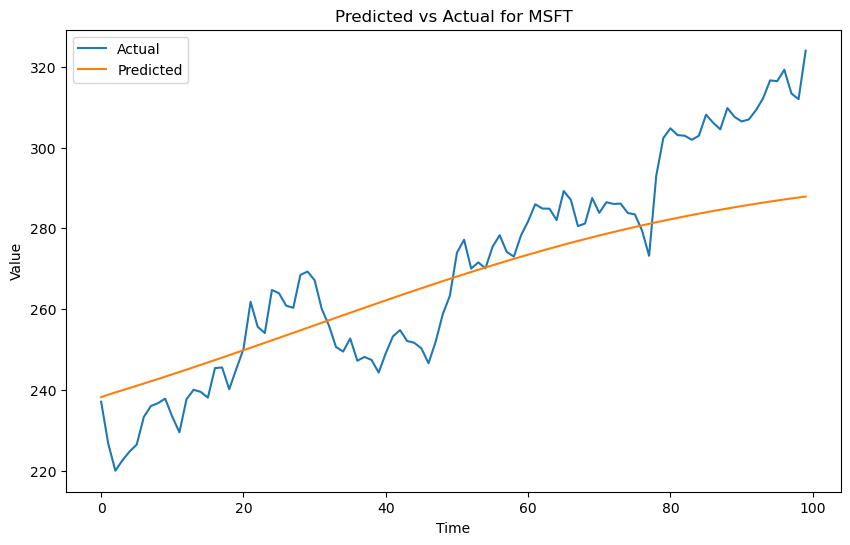

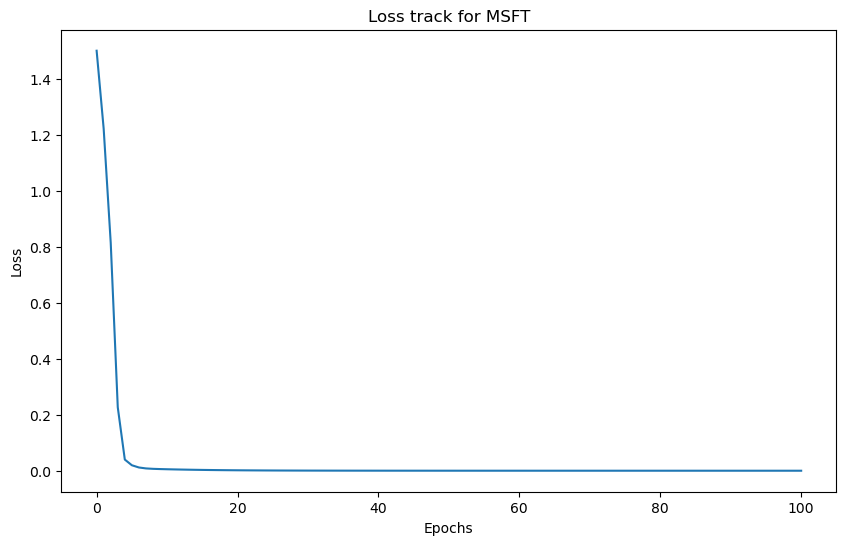

Evaluating model for ticker: MS
100


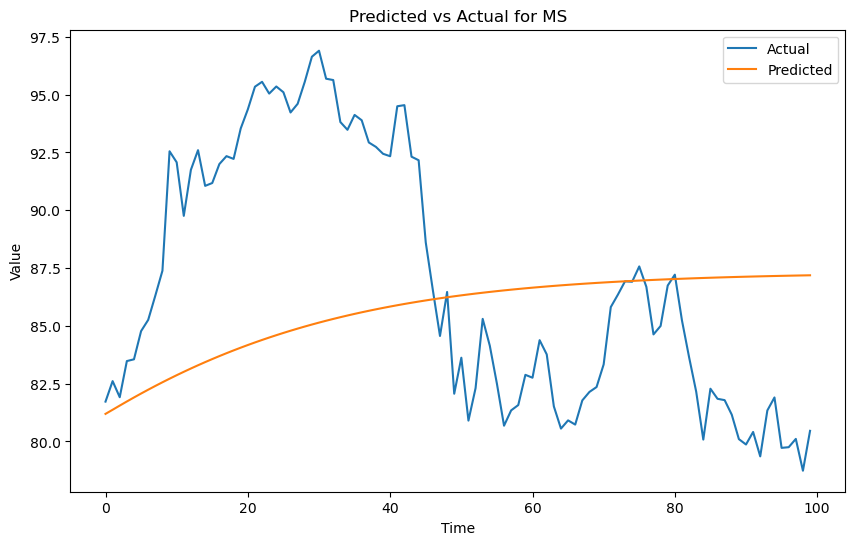

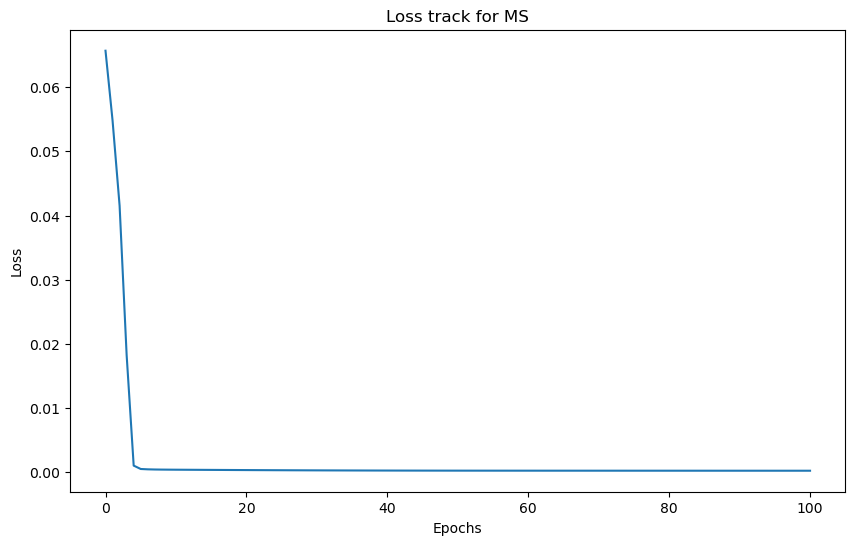

Evaluating model for ticker: NVDA
100


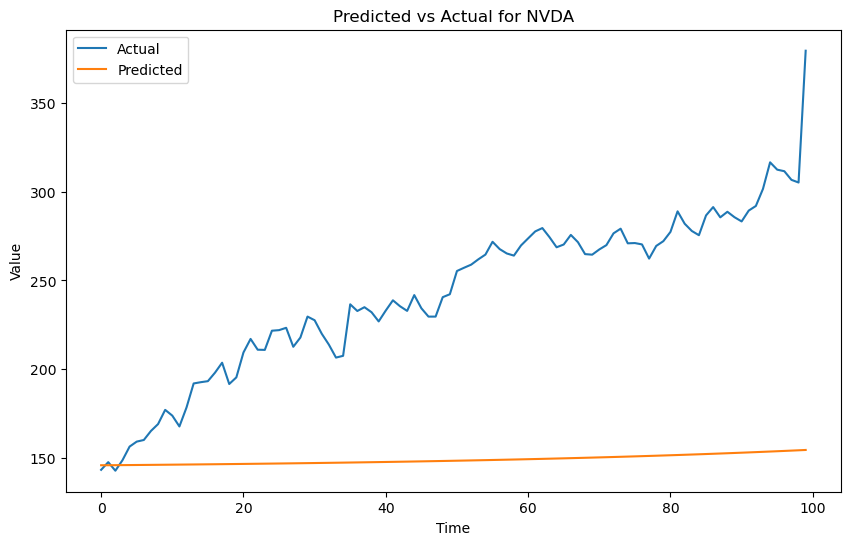

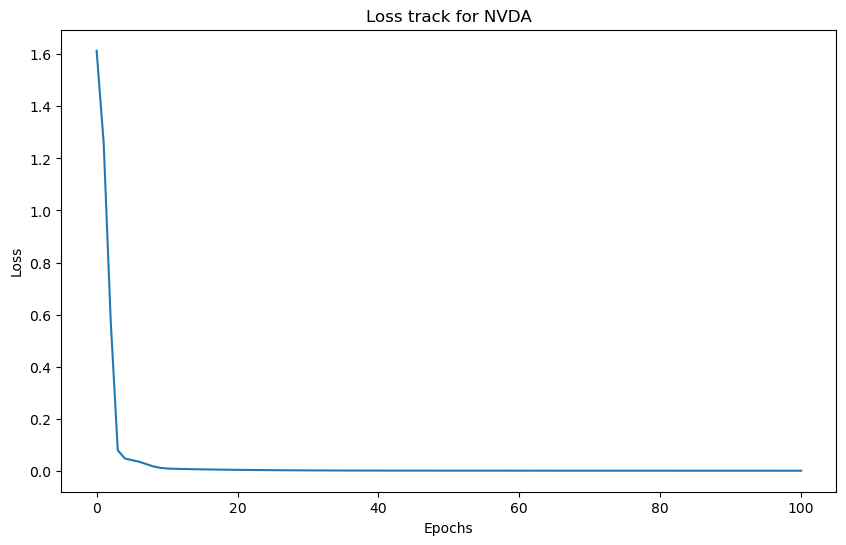

Evaluating model for ticker: TSLA
100


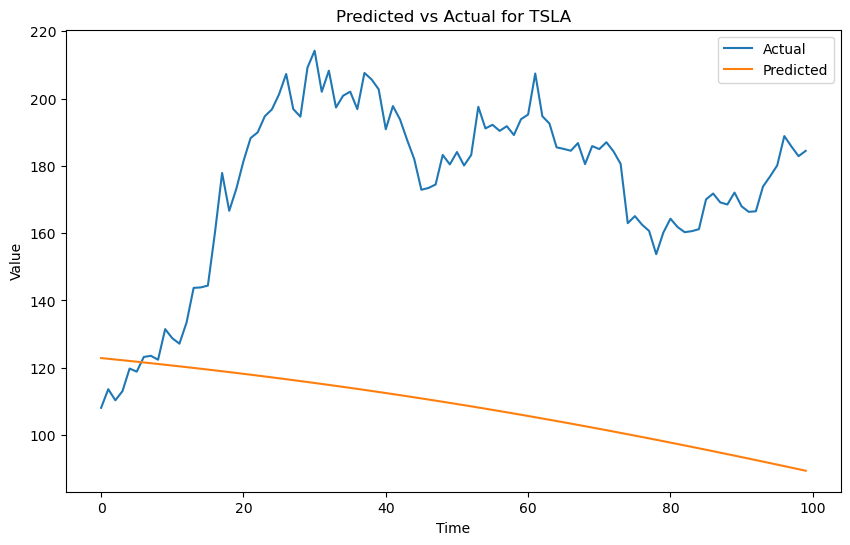

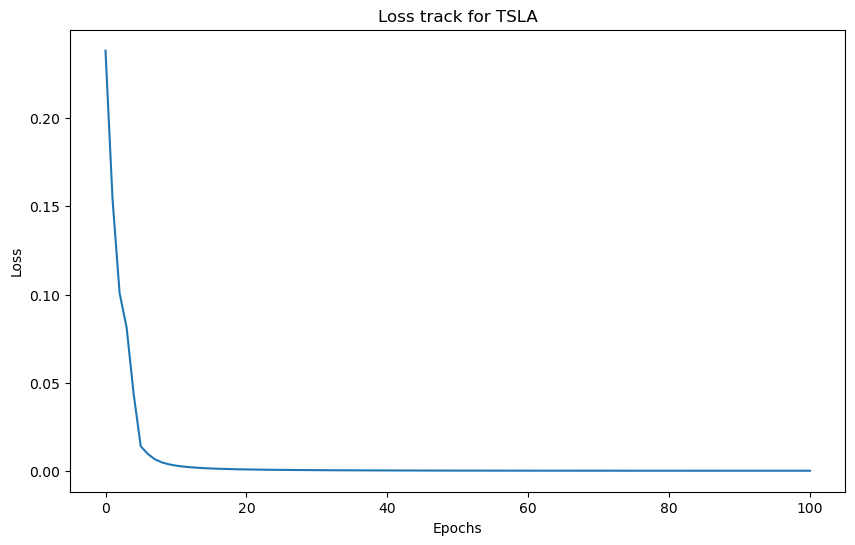

Evaluating model for ticker: VOO
100


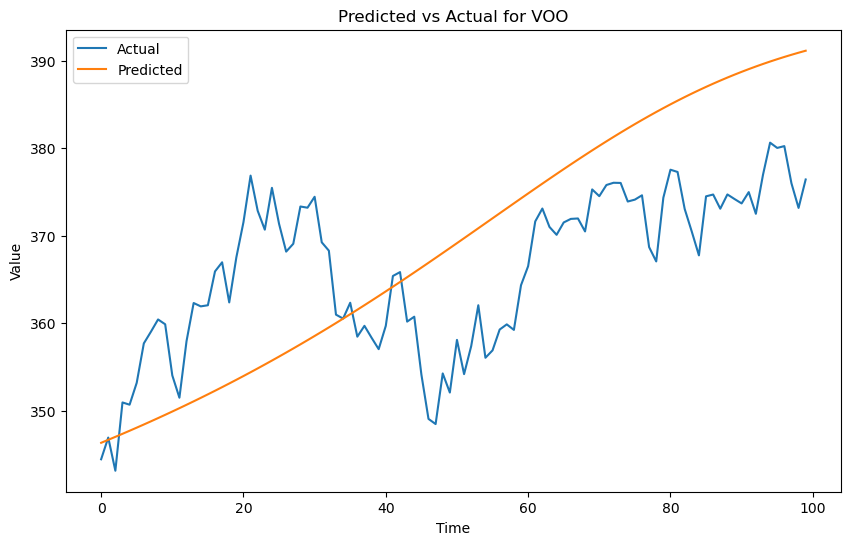

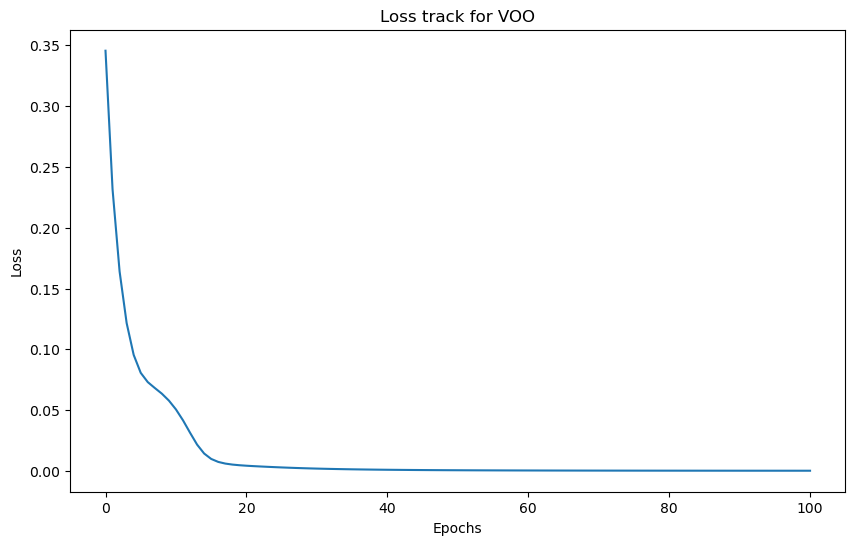

In [42]:
predicted_df, loss_df = MyLSTM.test(models,val_data,test_data, all_loss_tracks, scalars, seq_len)

In [43]:
nn_allocs = mpt.optimize_portfolio(predicted_df)
print("NN's Portfolio Allocation")
for val, ticker in zip(nn_allocs, l):
    print(ticker + ": " + str(round(val,3)))

NN's Portfolio Allocation
AAPL: 0.0
AMD: 0.0
AMZN: 0.015
F: 0.451
GOOG: 0.0
INTC: 0.009
JPM: 0.036
MSFT: 0.089
MS: 0.043
NVDA: 0.225
TSLA: 0.0
VOO: 0.137


In [44]:
mean_nn, std_nn, cr_nn, sr_nn = utils.sharpe_ratio_metrics(test_data, nn_allocs)
treynor_nn, beta_nn, alpha_nn = utils.treynor_ratio_metrics(
    test_data, nn_allocs, index_data
)
print("MyOptimizer Metrics")
print("Mean: " + str(mean_nn))
print("Std Dev: " + str(std_nn))
print("Cumulative Return: " + str(cr_nn))
print("Sharpe Ratio: " + str(sr_nn))
print("Treynor Ratio: " + str(treynor_nn))
print("Beta: " + str(beta_nn))
print("Alpha: " + str(alpha_nn))

MyOptimizer Metrics
Mean: 0.002802416046323475
Std Dev: 0.01678639148998479
Cumulative Return: 0.9396355455867333
Sharpe Ratio: 2.6501809873071767
Treynor Ratio: 0.0017744712999945157
Beta: 1.4694044622370237
Alpha: 0.0013550579061096621


In [45]:
dbscan_allocs = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5]
mean_dbscan, std_dbscan, cr_dbscan, sr_dbscan = utils.sharpe_ratio_metrics(test_data, dbscan_allocs)
treynor_dbscan, beta_dbscan, alpha_dbscan = utils.treynor_ratio_metrics(
    test_data, dbscan_allocs, index_data
)
print("MyOptimizer Metrics")
print("Mean: " + str(mean_dbscan))
print("Std Dev: " + str(std_dbscan))
print("Cumulative Return: " + str(cr_dbscan))
print("Sharpe Ratio: " + str(sr_dbscan))
print("Treynor Ratio: " + str(treynor_dbscan))
print("Beta: " + str(beta_dbscan))
print("Alpha: " + str(alpha_dbscan))

MyOptimizer Metrics
Mean: 0.0027407879184298445
Std Dev: 0.016598064395320144
Cumulative Return: 0.9116958581133567
Sharpe Ratio: 2.6213092282906105
Treynor Ratio: 0.0017632200549167142
Beta: 1.4438288127060206
Alpha: 0.0013186217015368565
